# **Рекомендательная система Онлайн-кинотеатра**

---

## **1. Бизнес-цель**

На всех развлекательных веб-сайтах или в интернет-магазинах представлены миллионы / миллиарды товаров. Покупателю становится сложно выбрать подходящий. В этом случае на помощь приходят рекомендательные системы, которые помогают пользователю найти нужный товар, минимизируя количество вариантов.

Рекомендательные системы в мире машинного обучения стали очень популярными и являются огромным преимуществом для таких технологических гигантов, как Netflix, Amazon и многих других, которые ориентируют свой контент на определенную аудиторию. Эти системы рекомендаций настолько точны в своих прогнозах, что могут динамически изменять состояние того, что пользователь видит на своей странице, в зависимости от взаимодействия пользователя с приложением.

Бизнес-целью для нас является:

- Создать систему рекомендаций фильмов на основе совместной фильтрации.
- Спрогнозировать оценку, которую пользователь поставил бы фильму, который он еще не оценил.
- Свести к минимуму разницу между прогнозируемым и фактическим рейтингом (RMSE and MAPE).


## **2. Сбор данных**

Набор данных был получен из Grouplens.

Ссылка : https://grouplens.org/datasets/movielens/20m/

Этот набор данных (ml20m) описывает 5-звездочный рейтинг и использование тегов в свободном тексте от MovieLens, сервиса рекомендаций по фильмам. Он содержит 20000263 рейтинга и 465564 приложения для присвоения тегов 27278 фильмам. Эти данные были созданы 138 493 пользователями в период с 09 января 1995 года по 31 марта 2015 года. Этот набор данных был создан 17 октября 2016 года.

Пользователи были выбраны случайным образом для включения. Все выбранные пользователи оценили не менее 20 фильмов. Демографическая информация не включена. Каждый пользователь представлен идентификатором, и никакая другая информация не предоставляется.

Данные содержатся в файлах "ratings.csv" and "movies.csv" data files.

In [1]:
# Connecting to Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [4]:
!pip install fuzzywuzzy
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357283 sha256=2e4d58d3e06e968b7c1114c6c48a109901373ae46e6a628d44e63c014968fa7a
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [5]:
from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [6]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## **3. Подготовка данных/Препроцессинг**

Мы начнем с загрузки и ознакомления с набором данных, чтобы подготовить данные для моделирования с помощью машинного обучения (ML).

In [7]:
# Loading the dataset

file_path = "/content/drive/MyDrive/Colab Notebooks/ML_Python"

movie_ratings = pd.read_csv(file_path + "/rating.csv", nrows=10000000)
movies = pd.read_csv(file_path + "/movie.csv")

In [8]:
# Creating a newId for every movie to reduce the range of existing movieId

movies["newId"] = range(1, movies["movieId"].nunique()+1)

In [9]:
# Преобразование timestamp в числовые значения (если это строки)
movie_ratings['timestamp'] = pd.to_datetime(movie_ratings['timestamp'], errors='coerce')

# movie_ratings.head()

# # Конвертация UTC timestamp в дату
movie_ratings["timestamp"] = movie_ratings['timestamp'].dt.date

# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
movie_ratings["movieId"] = movie_ratings["newId"]
movies["movieId"] = movies["newId"]

In [10]:
# Dropping the newId from the datasets
movie_ratings.drop(["newId"], axis=1, inplace=True)
movies.drop(["newId"], axis=1, inplace=True)

# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)

In [11]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)


The number of records are :  10000000
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


In [12]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
1,53434,19,1.0,1996-01-29,Ace Ventura: When Nature Calls (1995),Comedy
2,20821,32,5.0,1996-01-29,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,46380,39,5.0,1996-02-02,Clueless (1995),Comedy|Romance
4,46380,52,4.0,1996-02-02,Mighty Aphrodite (1995),Comedy|Drama|Romance


Выводы:

1. Существует более 20 миллионов записей данных.
2. Есть 6 фичей: идентификатор пользователя, идентификатор фильма, рейтинг, дата, название и жанры.

### **3.1 Очистка данных**

Мы начнем с очистки данных таким образом, чтобы мы могли обрабатывать пропущенные значения, выбросы, редкие значения и удалять ненужные функции, которые не содержат полезной информации.


In [13]:
# Checking for duplicates

print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


Вывод:

В наборе данных нет повторяющихся записей.

In [14]:
# Checking the columns' titles and datatypes

movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   date     object 
 4   title    object 
 5   genres   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 457.8+ MB


#### **3.1.1 Handling Missing Values**

Identifying the features that have some missing values and imputing them.

In [15]:
# Checking the number of missing values in data

movie_ratings.isna().sum()

,0
userId,0
movieId,0
rating,0
date,0
title,0
genres,0


Выводы:

1. Похоже, что набор данных находится в хорошем состоянии, так как мы не видим никаких пропущенных значений, и это хорошо.

### **3.2 Предварительный анализ данных**

После выполнения этапов очистки данных мы теперь можем работать с набором данных, чтобы обнаружить закономерности и взаимосвязи, которые помогут лучше понять данные.

#### **3.2.1 Анализ фичей**

Анализируем каждую фичу в отдельности, чтобы получить представление о данных и обнаружить отклонения.

In [16]:
# Checking the feature "userID"

total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  69139
The top 5 userID in the dataset are : 
 userId
8405     7515
34576    5356
59477    4988
8963     4524
15617    4354
Name: count, dtype: int64


Выводы:

1. "userId" - это пользователи, которые были выбраны случайным образом для включения, и их идентификаторы были анонимизированы.
2. В наборе данных более 138 тысяч уникальных пользователей.
3. Идентификатор пользователя 118205 содержит около 9 тысяч записей в наборе данных.

In [17]:
# Checking the feature "movieID"

total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  23304
The top 5 movieID in the dataset are : 
 movieId
294    33497
353    33031
316    31623
588    31533
477    29899
Name: count, dtype: int64


Выводы:

1. "MovieID" представляет фильмы с хотя бы одним рейтингом или тегом в наборе данных.
2. В наборе данных более 26 тысяч уникальных фильмов.
3. MovieID 294, 353, 316 и 588 - это несколько популярных фильмов, рейтинг которых превысил 60 тысяч раз.

In [18]:
# Helper function to Change the numeric label in terms of Millions

def changingLabels(number):

    return str(number/10**6) + "M"

In [19]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
1,53434,19,1.0,1996-01-29,Ace Ventura: When Nature Calls (1995),Comedy
2,20821,32,5.0,1996-01-29,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,46380,39,5.0,1996-02-02,Clueless (1995),Comedy|Romance
4,46380,52,4.0,1996-02-02,Mighty Aphrodite (1995),Comedy|Drama|Romance


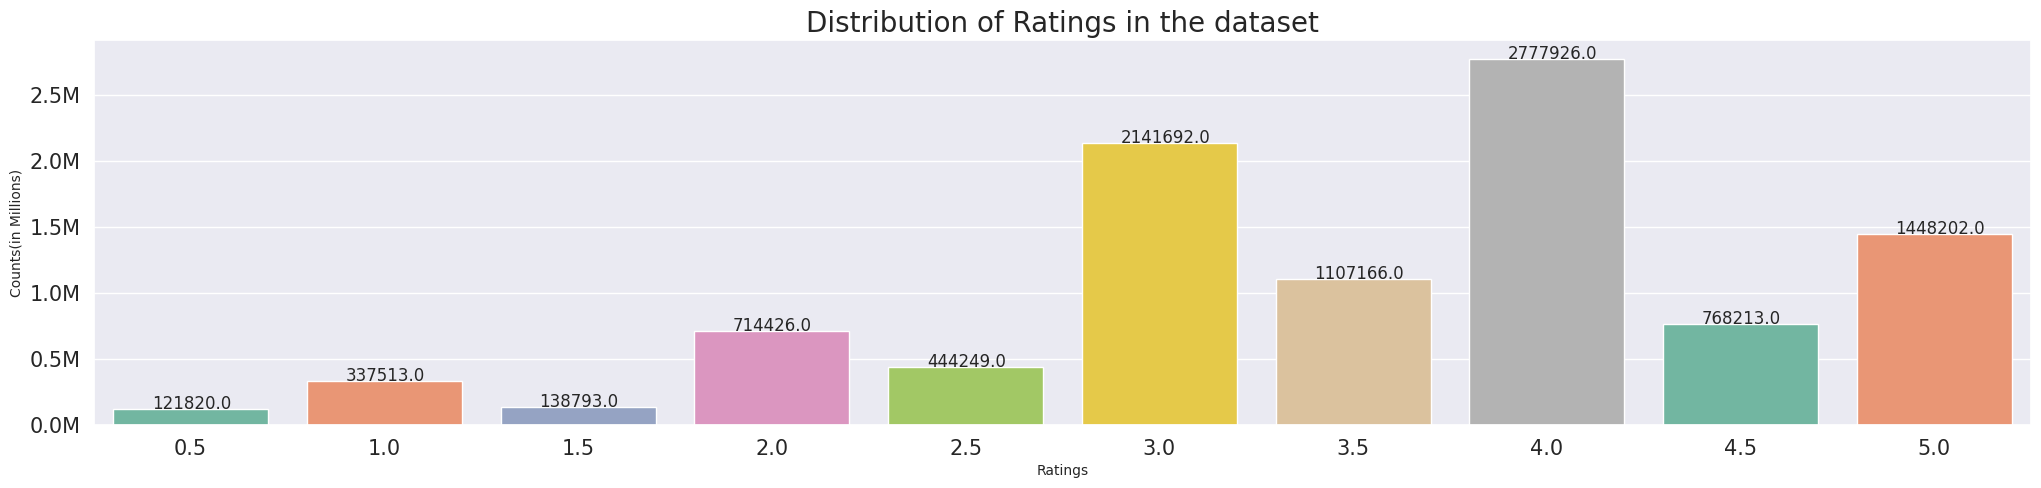

In [20]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=movie_ratings, ax=axes, palette="Set2")

# Установка меток по оси y
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])

# Добавление значений на бары
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 100))

plt.tick_params(labelsize=15)
plt.title("Distribution of Ratings in the dataset", fontsize=20)
plt.xlabel("Ratings", fontsize=10)
plt.ylabel("Counts(in Millions)", fontsize=10)
plt.show()

Выводы:

1. Оценки, поставленные пользователями фильмам, находятся в диапазоне от 0,5 до 5.
2. Большая часть фильмов получила оценку 3, 3,5 или 4 от пользователей.
3. Распределение оценок выглядит немного искаженным, поскольку большая часть оценок находится в диапазоне от 3 до 5.

In [21]:
# Checking the feature "date"

print("The count of unique date in the dataset is : ", movie_ratings["date"].nunique())
print("The first rating was given on : ", movie_ratings["date"].min())
print("The latest rating was given on : ", movie_ratings["date"].max())
print("The top 5 date in the dataset are : \n", movie_ratings["date"].value_counts()[:5])

The count of unique date in the dataset is :  6898
The first rating was given on :  1995-01-09
The latest rating was given on :  2015-03-31
The top 5 date in the dataset are : 
 date
2000-11-20    48812
2005-03-22    39663
1999-12-11    33315
2000-11-21    28983
2008-10-29    27860
Name: count, dtype: int64


Выводы:

1. Существует ~7 тысяч уникальных дат, когда пользователи ставили оценки фильму.
2. Первая оценка была дана 1995-01-09, а последняя - 2015-03-31.
3. 2000-11-20 наблюдалось около 48К+ рейтингов.

In [22]:
# Checking the feature "title"

movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  23292
The top 5 title in the dataset are : 
 title
Pulp Fiction (1994)                 33497
Forrest Gump (1994)                 33031
Shawshank Redemption, The (1994)    31623
Silence of the Lambs, The (1991)    31533
Jurassic Park (1993)                29899
Name: count, dtype: int64


Наблюдения:

1. В наборе данных более 23 тысяч уникальных названий фильмов.
2. Криминальное чтиво, Форрест Гамп, Побег из Шоушенка и Молчание ягнят - 4 лучших фильма по количеству нет. из полученных оценок, которые превышают 30К+ для каждой.

In [23]:
# Extract unique Genres along with their count

unique_genres = {}

def ExtractGenres(x):
    for g in x.split("|"):
        if g not in unique_genres.keys():
            unique_genres[g] = 1
        else:
            unique_genres[g] = unique_genres[g] + 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres Extracted from the dataset.")

Genres Extracted from the dataset.


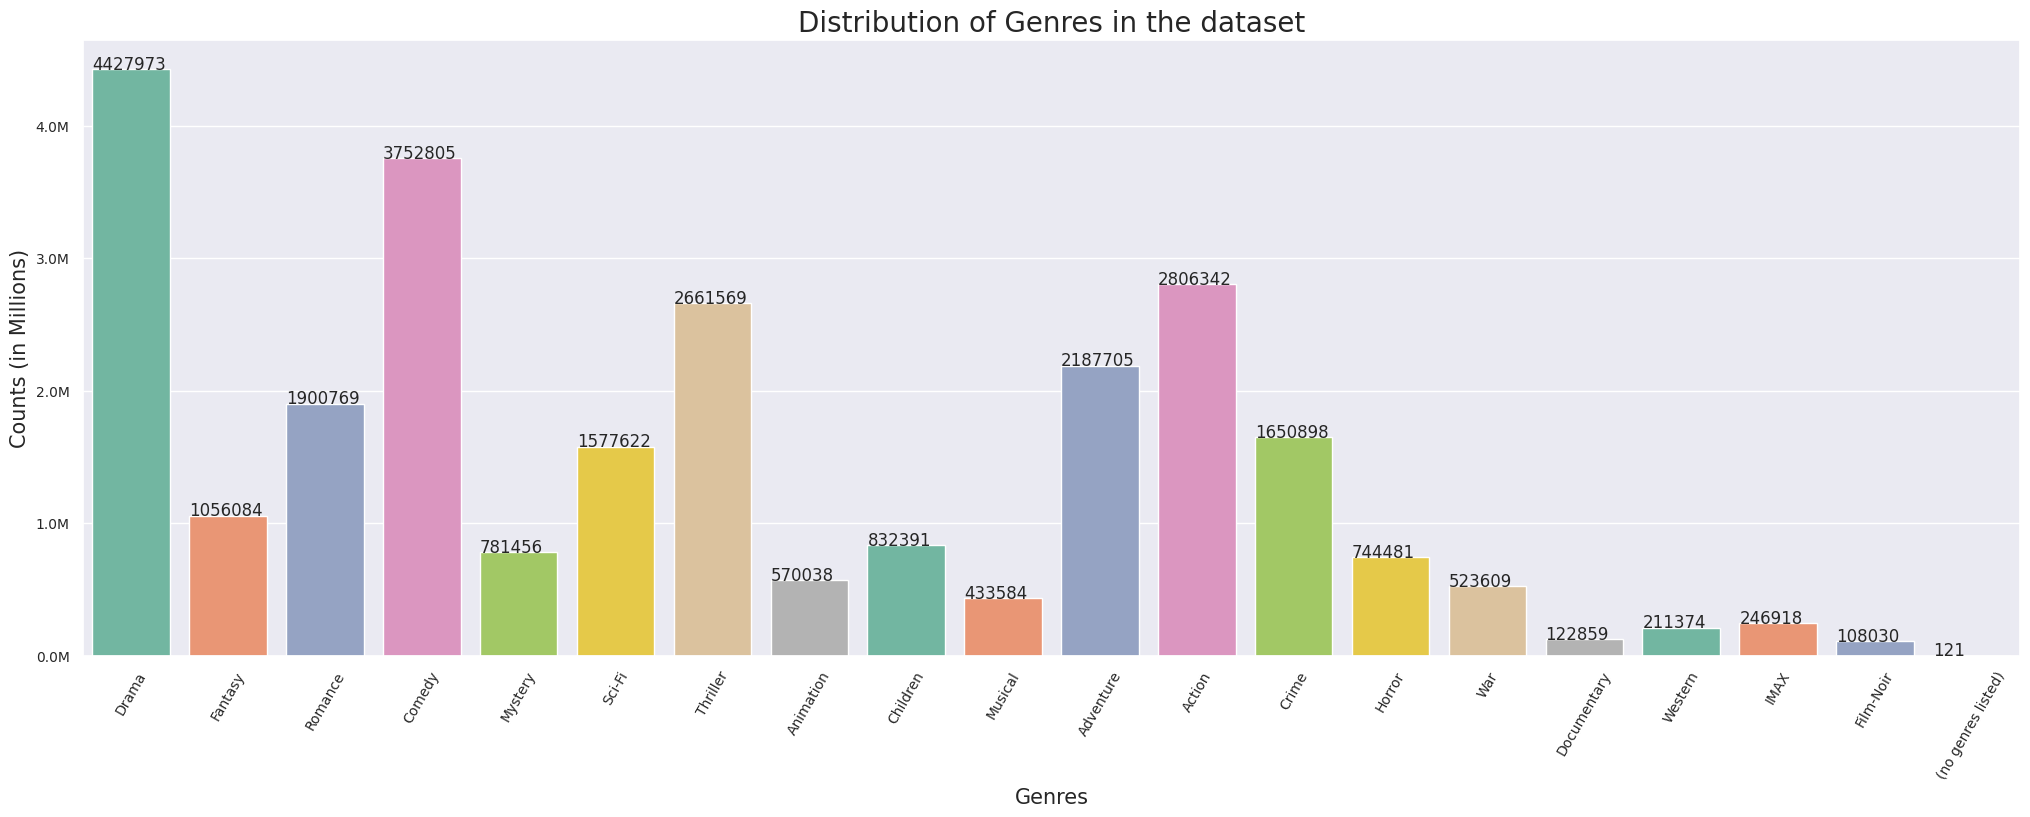

In [24]:
# Visualizing the feature "Genres"

genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"]

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes, palette="Set2")
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Выводы:

1. Существует 19 фильмов разных жанров, в то время как есть несколько фильмов, жанр которых не был упомянут.
2. Драма, комедия, боевик и триллер - это 4 лучших жанра фильмов, представленных в наборе данных.

In [25]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
1,53434,19,1.0,1996-01-29,Ace Ventura: When Nature Calls (1995),Comedy
2,20821,32,5.0,1996-01-29,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,46380,39,5.0,1996-02-02,Clueless (1995),Comedy|Romance
4,46380,52,4.0,1996-02-02,Mighty Aphrodite (1995),Comedy|Drama|Romance


#### **3.2.2 Train & test Splitting**

Splitting the data into train and test sets before proceeding towards further EDA and Feature Engineering.

In [26]:
# Creating the train test set

file_path = "/content/drive/MyDrive/Colab Notebooks/ML_Python"

if not os.path.isfile(file_path + "/TrainData.pkl"):
    print("Creating Train Data and saving it..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle(file_path + "/TrainData.pkl")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Train Data..")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile(file_path + "/TestData.pkl"):
    print("Creating Test Data and saving it..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle(file_path + "/TestData.pkl")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Test Data..")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

Loading Train Data..
Loading Test Data..


In [27]:
Train_Data.head()

,userId,movieId,rating,date,title,genres
0,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
1,53434,19,1.0,1996-01-29,Ace Ventura: When Nature Calls (1995),Comedy
2,20821,32,5.0,1996-01-29,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,46380,39,5.0,1996-02-02,Clueless (1995),Comedy|Romance
4,46380,52,4.0,1996-02-02,Mighty Aphrodite (1995),Comedy|Drama|Romance


In [28]:
# Creating list of unique movies from Train Set

movie_list_in_training = Train_Data.drop_duplicates(subset=["title"], keep="first")[["movieId", "title", "genres"]]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

,movieId,title,genres
0,1154,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
1,19,Ace Ventura: When Nature Calls (1995),Comedy
2,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,39,Clueless (1995),Comedy|Romance
4,52,Mighty Aphrodite (1995),Comedy|Drama|Romance


In [29]:
# Checking the basic statistics for the training data

print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

Total Train Data..
Total number of movie ratings in train data :  8000000
Number of unique users in train data :  56127
Number of unique movies in train data :  12163


#### **3.2.3 Би-вариативный анализ**

Совместный анализ множества объектов для выявления взаимосвязей и паттернов.  

---

#####**1. Анализ распределения рейтингов**

In [30]:
# Checking basic statistics for "rating"

print("The basic statistics for the feature is : \n", Train_Data["rating"].describe())

The basic statistics for the feature is : 
 count    8.000000e+06
mean     3.512331e+00
std      1.060149e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


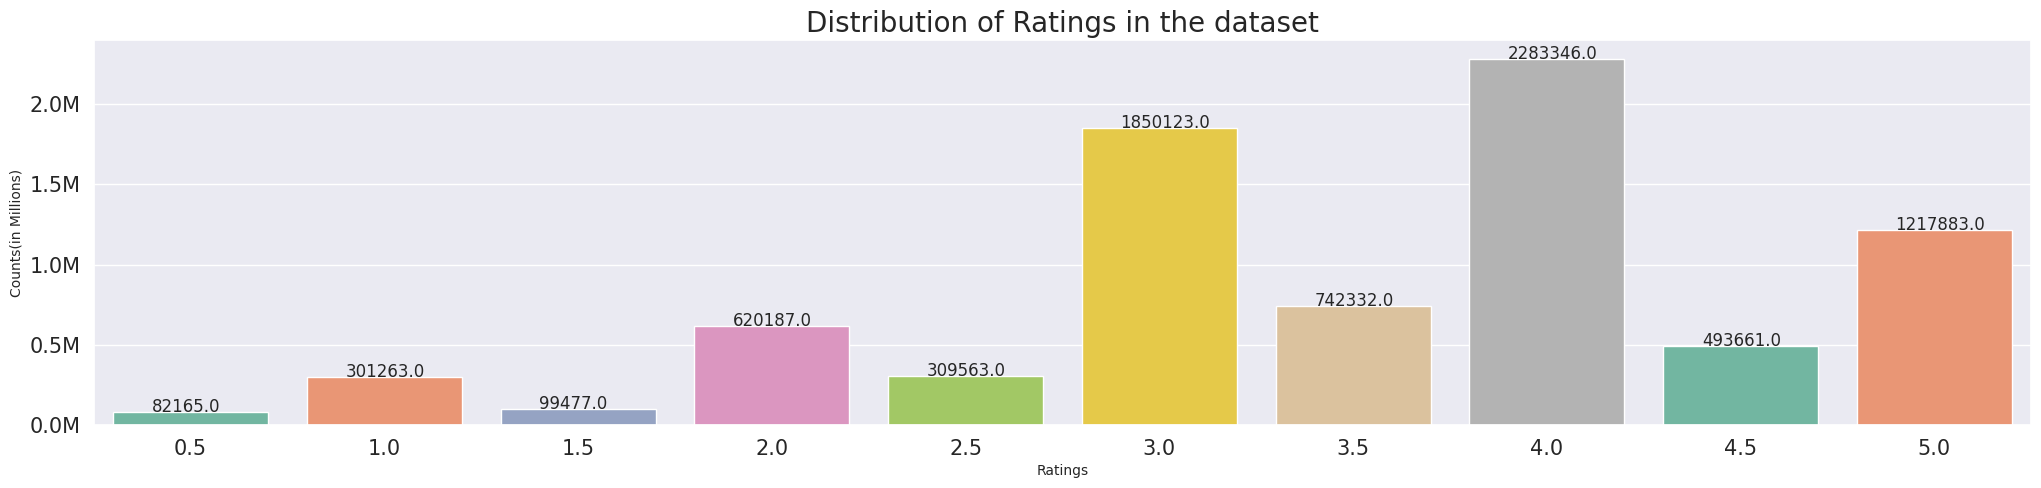

In [31]:
# Visualizing the "rating" for the train set

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=Train_Data, ax=axes, palette="Set2")
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

Выводы:

1. Распределение оценок, похоже, такое же, как и раньше.
2. Среднее и медианное значения очень близки к отметке 3,5.

---

#####**2.  Анализ количества рейтингов с указанием даты.**

In [32]:
# Extracting the day of week from the date when rating was provided

Train_Data["date"] = pd.to_datetime(Train_Data["date"], errors='coerce')
Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime('%A')
Train_Data["Weekday"] = Train_Data["date"].apply(lambda x : 1 if x.dayofweek > 5 else 0)

In [33]:
# Converting the number into 'Ks.

def ChangingLabelsInK(number):
    return str(int(number/10**3)) + "K"

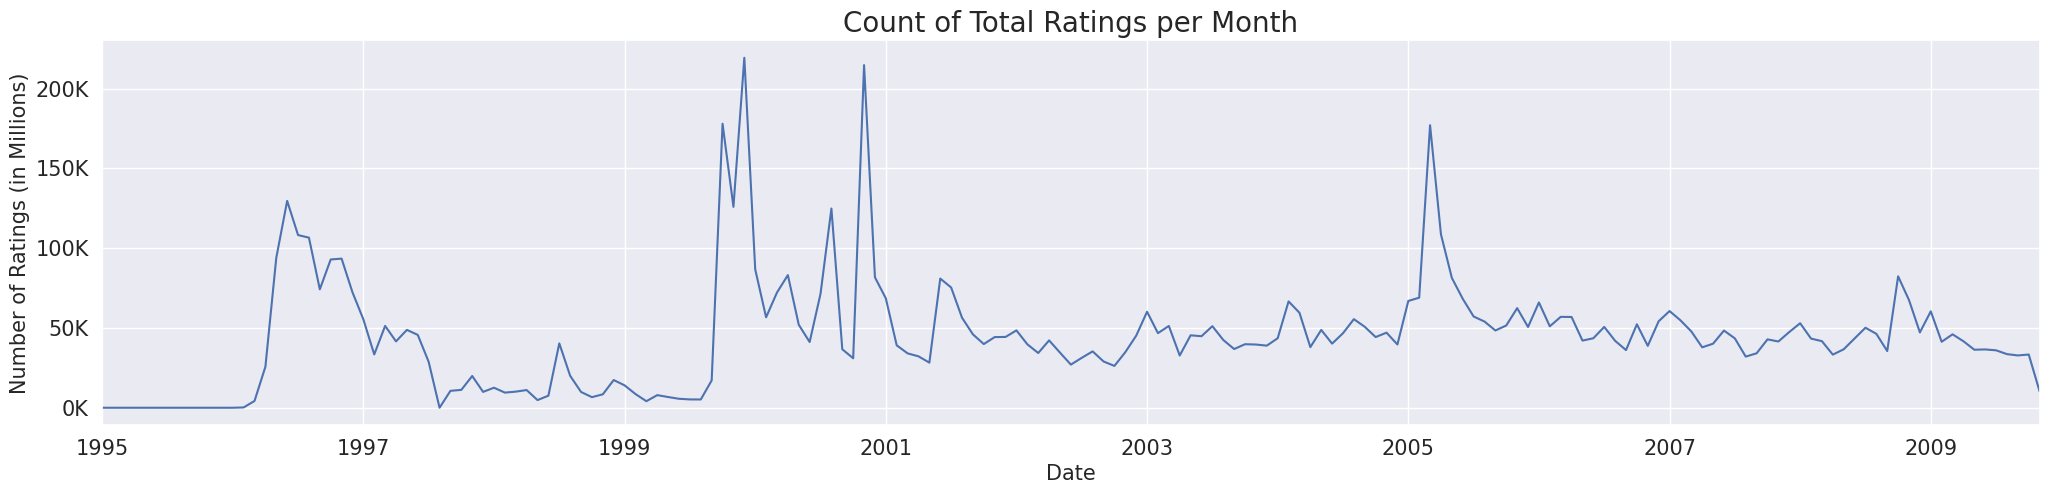

In [34]:
# Visualizing the count of total ratings made per month

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
axes = Train_Data.resample("m", on = "date")["rating"].count().plot()

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in Millions)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

Выводы:

1. Количество рейтингов в месяц было очень высоким в течение нескольких месяцев с 1996 по 1998 год.
2. Аналогично, после 2000-х годов есть несколько месяцев, в которых количество рейтингов в месяц было очень высоким. рейтингов.
3. Количество остается стабильным с 2001 по 2010 год, с резким скачком в течение нескольких месяцев 2006 года.

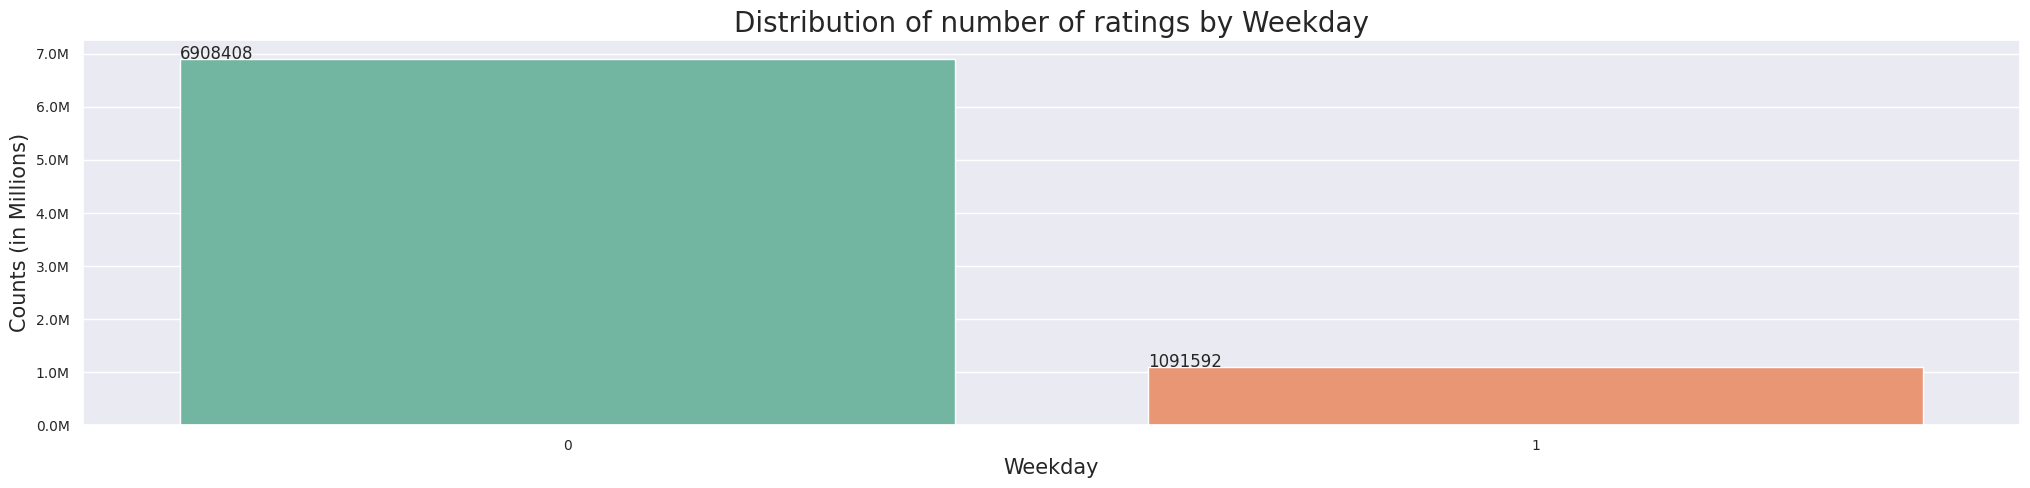

In [35]:
# Visualizing the count of ratings by weekday

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="Weekday", y="rating" , data=Train_Data.groupby(by=["Weekday"], as_index=False)["rating"].count(), ax=axes, palette="Set2")
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

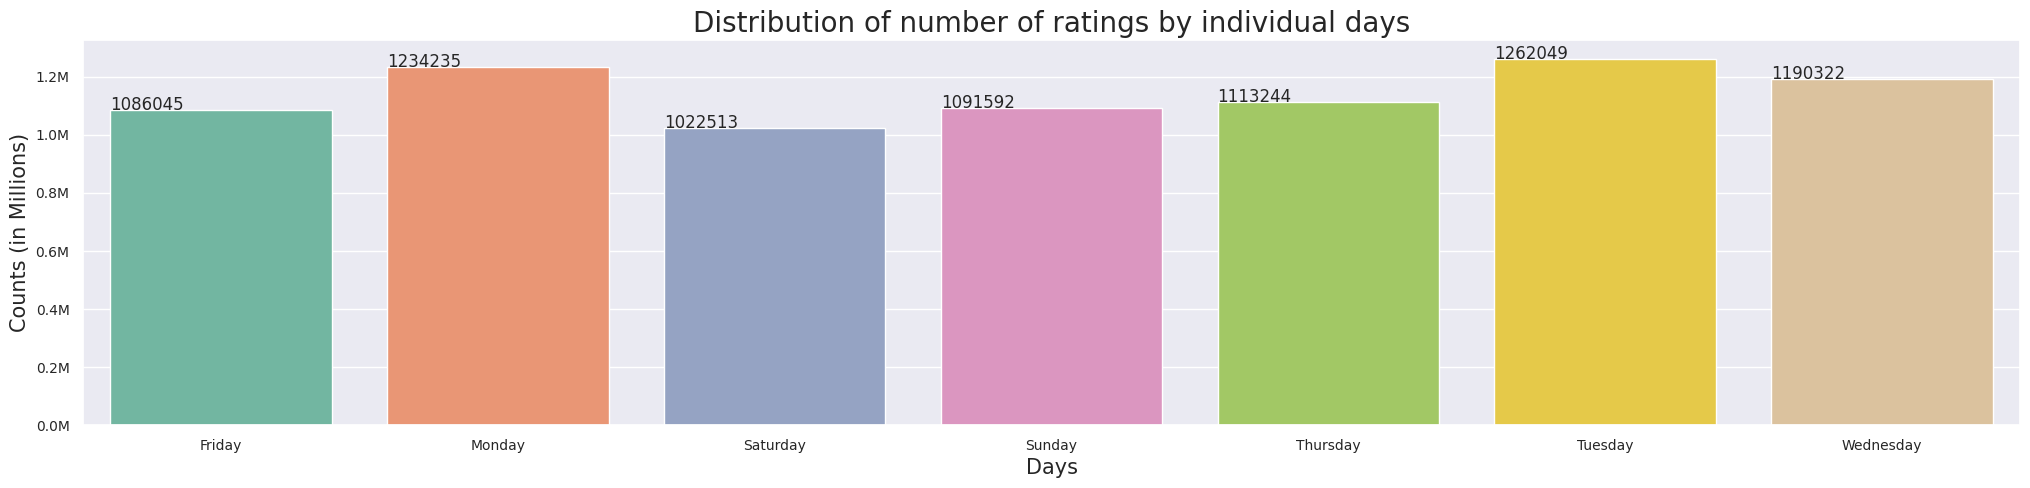

In [36]:
# Visualizing the count of ratings by individual days of the week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="DayOfWeek", y="rating" , data=Train_Data.groupby(by=["DayOfWeek"], as_index=False)["rating"].count(), ax=axes, palette="Set2")
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by individual days", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Замечания:

1. Количество оценок не слишком сильно зависит от дней недели.
2. "Понедельник" и "вторник" явно имеют большее количество оценок, чем любые другие дни.
3. Количество рейтингов в выходные явно значительно меньше, чем в будние дни.

---

#####**3. Анализ средних рейтингов по дате.**

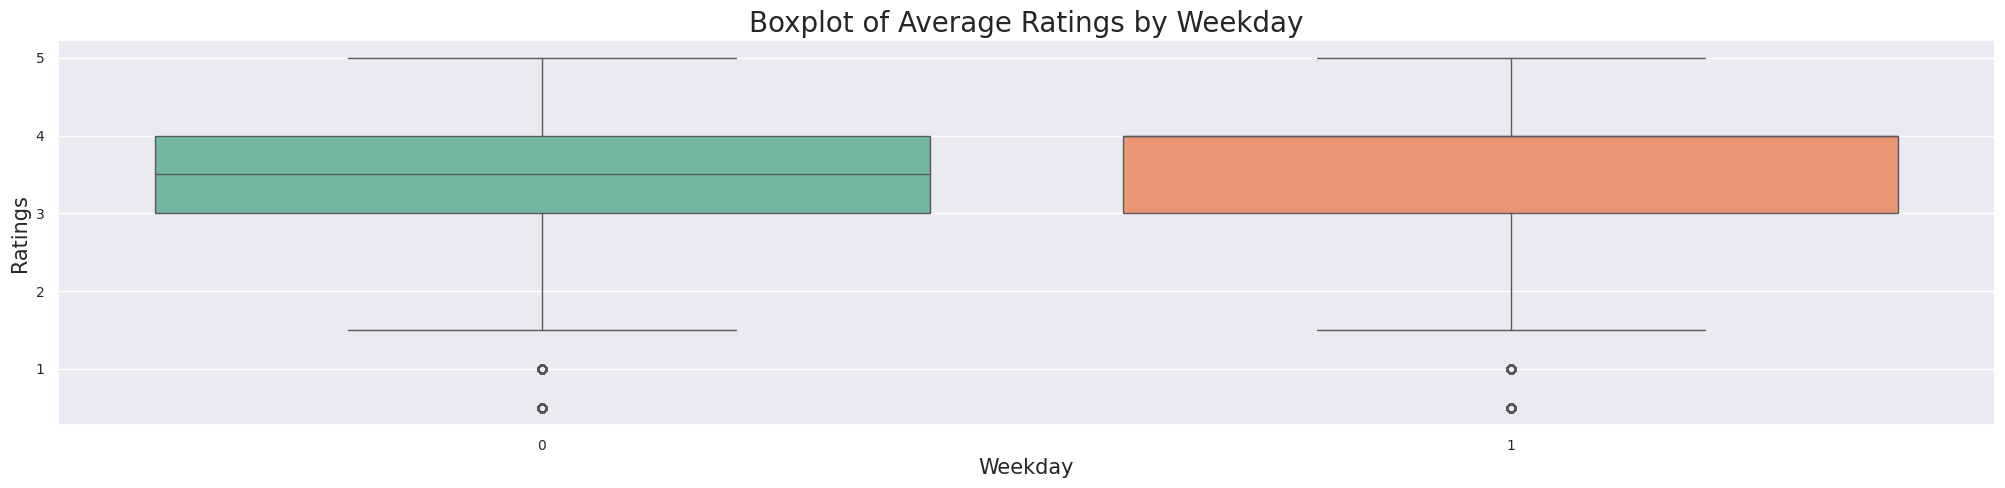

In [37]:
# Visualizing the average ratings by weekday

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="Weekday", y="rating" , data=Train_Data, ax=axes, palette="Set2")

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

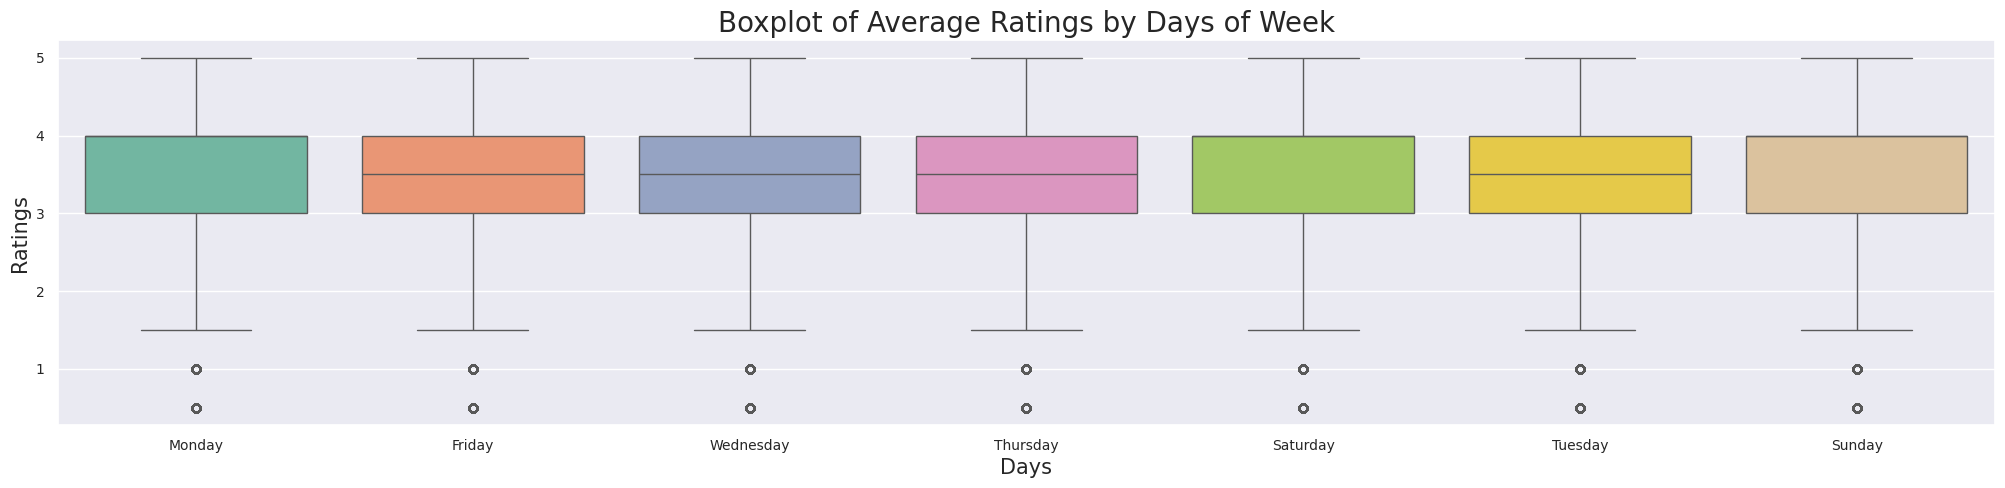

In [38]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="DayOfWeek", y="rating", data=Train_Data, ax=axes, palette="Set2")

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Days of Week", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

Выводы:

1. Средние оценки, данные пользователем, похоже, не различаются по дням недели и выходным.
2. Даже когда мы строим средние оценки по отдельным дням, они кажутся одинаковыми для всех отдельных дней.

---

#####**4. Анализ оценок, выставленных Пользователями.**

In [39]:
# Calculating the number of ratings given by individual users

no_of_rated_movies_per_user = Train_Data.groupby(by=["userId"], as_index=False)["rating"].count().sort_values(by="rating", ascending=False)
no_of_rated_movies_per_user.reset_index(drop=True, inplace=True)

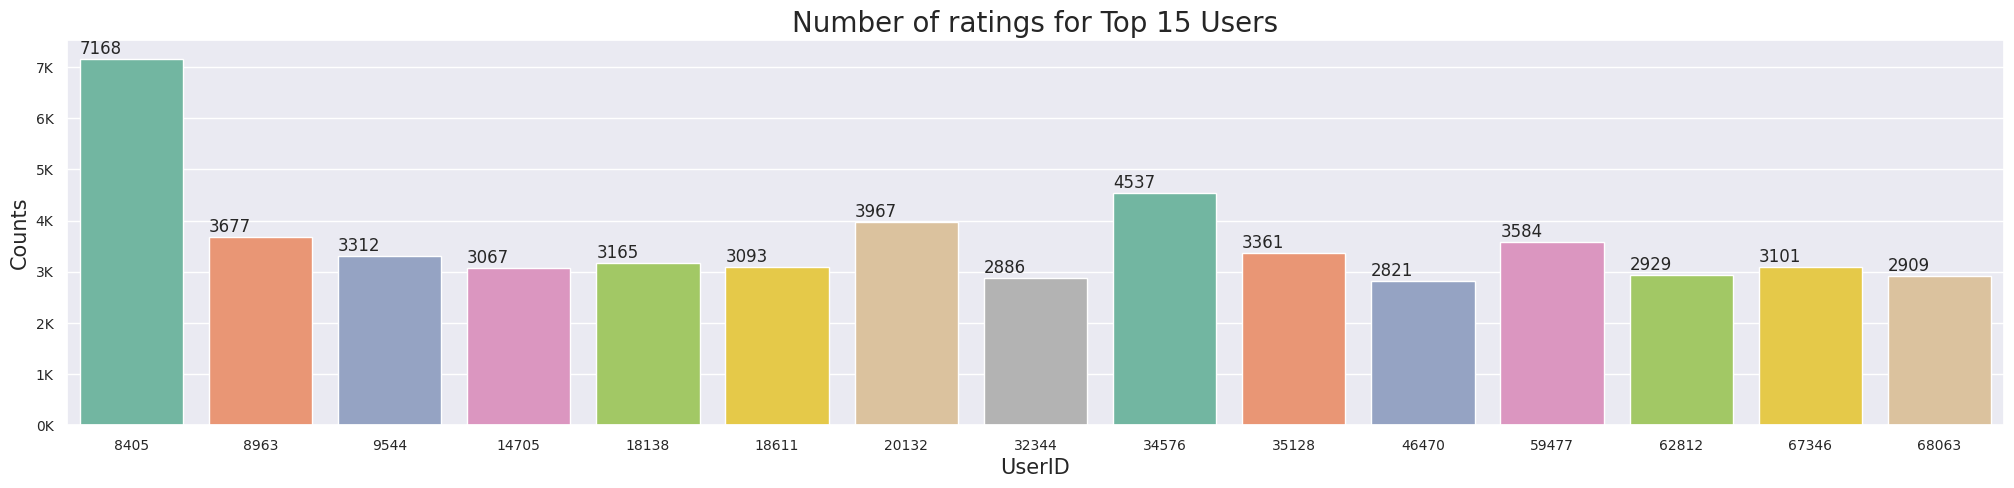

In [40]:
# Visualizing the count of ratings by individual users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="rating" , data=no_of_rated_movies_per_user[:15], ax=axes, palette="Set2")
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Users", fontsize = 20)
plt.xlabel("UserID", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.show()

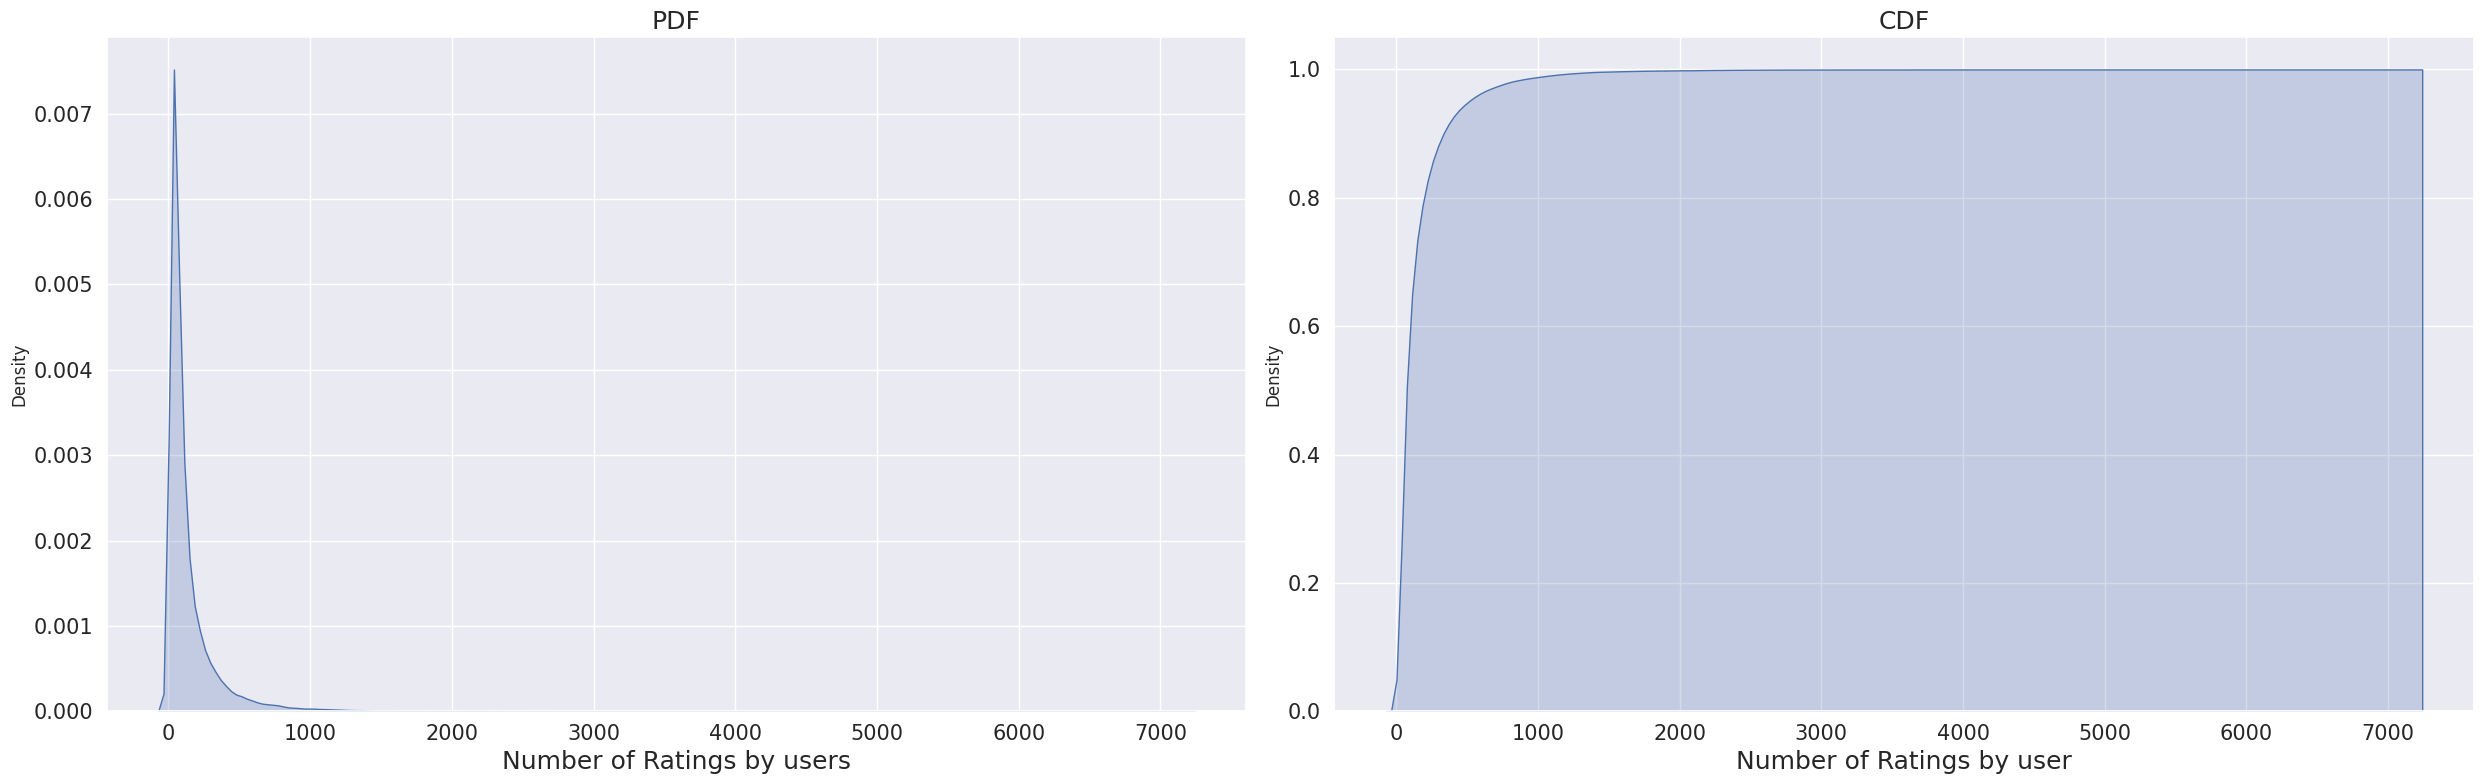

In [41]:
# Visualizing the count of ratings by individual users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

sns.kdeplot(no_of_rated_movies_per_user["rating"], shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by users", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user["rating"], shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

In [42]:
# Checking the basic statistics for the number of ratings per user

print("Information about no. of ratings by users : \n", no_of_rated_movies_per_user["rating"].describe())

Information about no. of ratings by users : 
 count    56127.000000
mean       142.533896
std        214.736842
min          1.000000
25%         35.000000
50%         69.000000
75%        155.000000
max       7168.000000
Name: rating, dtype: float64


In [43]:
quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0.9, 1.01,0.01))
qvalue = np.arange(0.9, 1.01,0.01)
for ctr in qvalue:
    print("The {}th quantile value is : {}".format(int(ctr*100), quantiles[ctr]))

The 90th quantile value is : 332.0
The 91th quantile value is : 355.6600000000035
The 92th quantile value is : 384.0
The 93th quantile value is : 416.0
The 94th quantile value is : 457.0
The 95th quantile value is : 509.0
The 96th quantile value is : 575.0
The 97th quantile value is : 666.0
The 98th quantile value is : 797.0
The 99th quantile value is : 1067.7400000000052
The 100th quantile value is : 7168.0


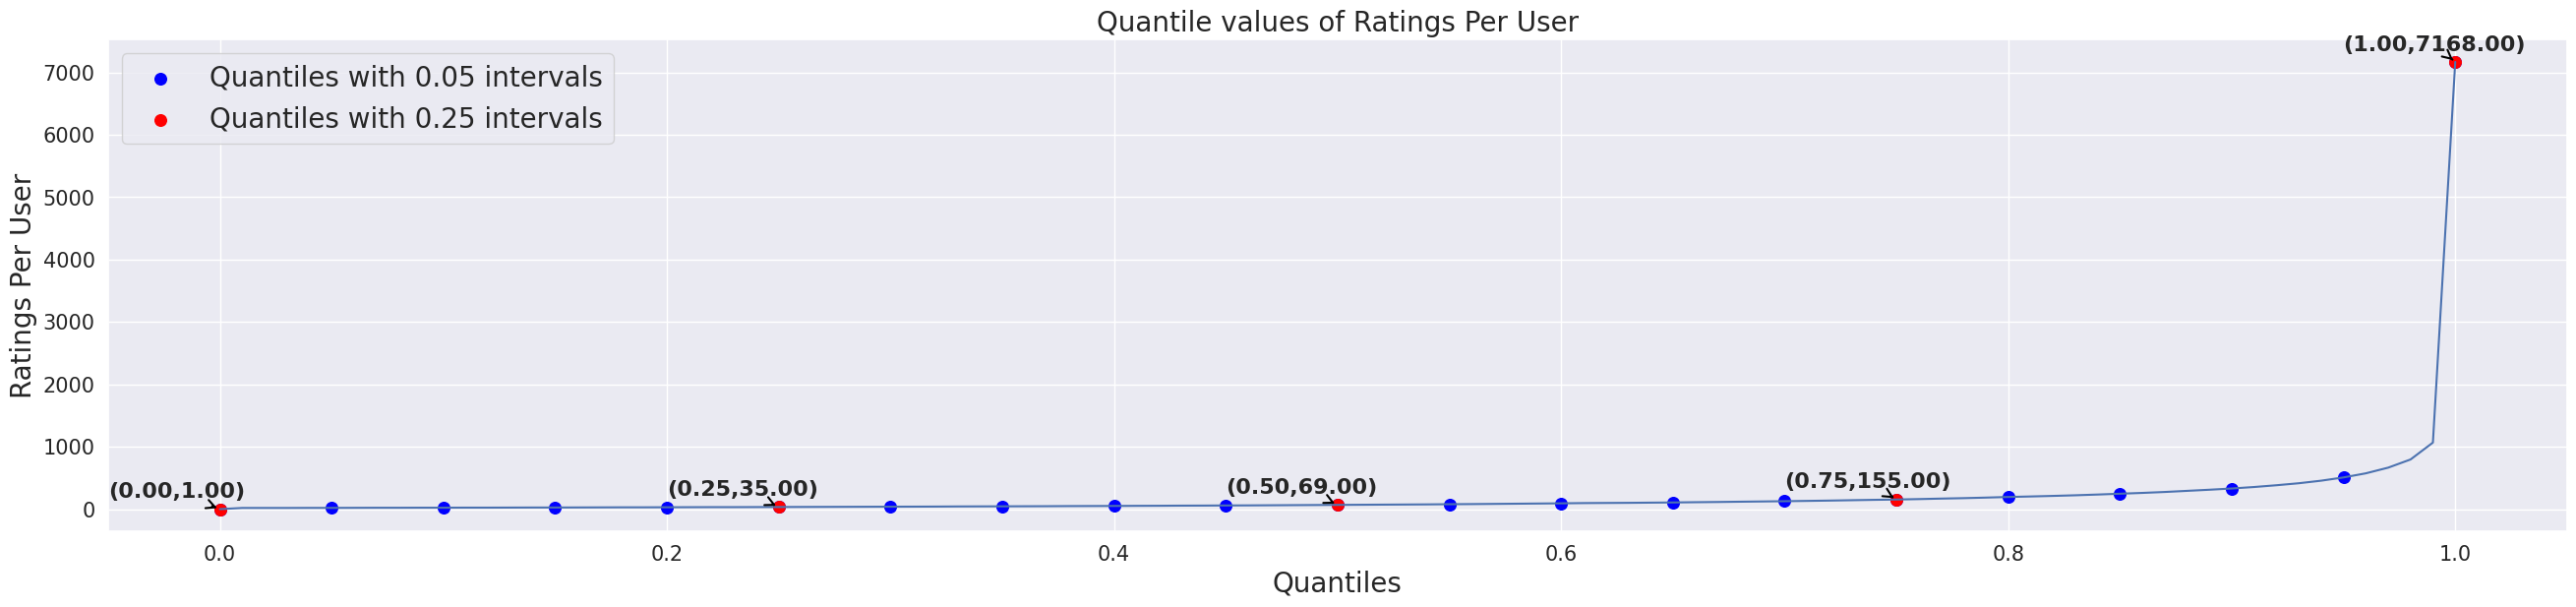

In [44]:
quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0, 1.01, 0.01))

fig = plt.figure(figsize=(25, 5))
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile values of Ratings Per User", fontsize=20)
axes.set_xlabel("Quantiles", fontsize=20)
axes.set_ylabel("Ratings Per User", fontsize=20)

axes.plot(quantiles)

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c="blue", s=70, label="Quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c="red", s=70, label="Quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize=20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    axes.annotate('({:.2f},{:.2f})'.format(x, y),
                  xy=(x, y),
                  fontweight='bold',
                  fontsize=16,
                  xytext=(x - 0.05, y + 180),
                  arrowprops=dict(arrowstyle='->', lw=1.5, color='black'))

axes.tick_params(labelsize=15)

plt.show()

Выводы:

1. 10 лучших пользователей, как правило, оценили более 4 тысяч раз, что кажется немного экстремальным поведением.
2. Идентификатор пользователя 118205 оценил более 7 тысяч раз, что кажется удивительным.
3. Из графика KDE ясно видно, что количество оценок сильно смещено вправо, и большинство оценок пользователей находится в диапазоне 0-1000.
4. Аналогично, приведенный выше график CDF показывает, что почти 99% пользователей дают очень мало оценок.
5. Среднее количество оценок, которые дает пользователь, равно 142, в то время как медиана равна 69.
6. Количество фильмов начинает резко увеличиваться с 90-го процентиля.

In [45]:
# Calculating average ratings given by individual users

avg_ratings_per_user = Train_Data.groupby(by = ["userId"], as_index=False)["rating"].mean()
avg_ratings_per_user = avg_ratings_per_user.reset_index(drop=True)
avg_ratings_per_user = avg_ratings_per_user.merge(no_of_rated_movies_per_user[["userId", "rating"]], how="left", on="userId")
avg_ratings_per_user.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_user = avg_ratings_per_user.sort_values("num_of_rating", ascending=False)

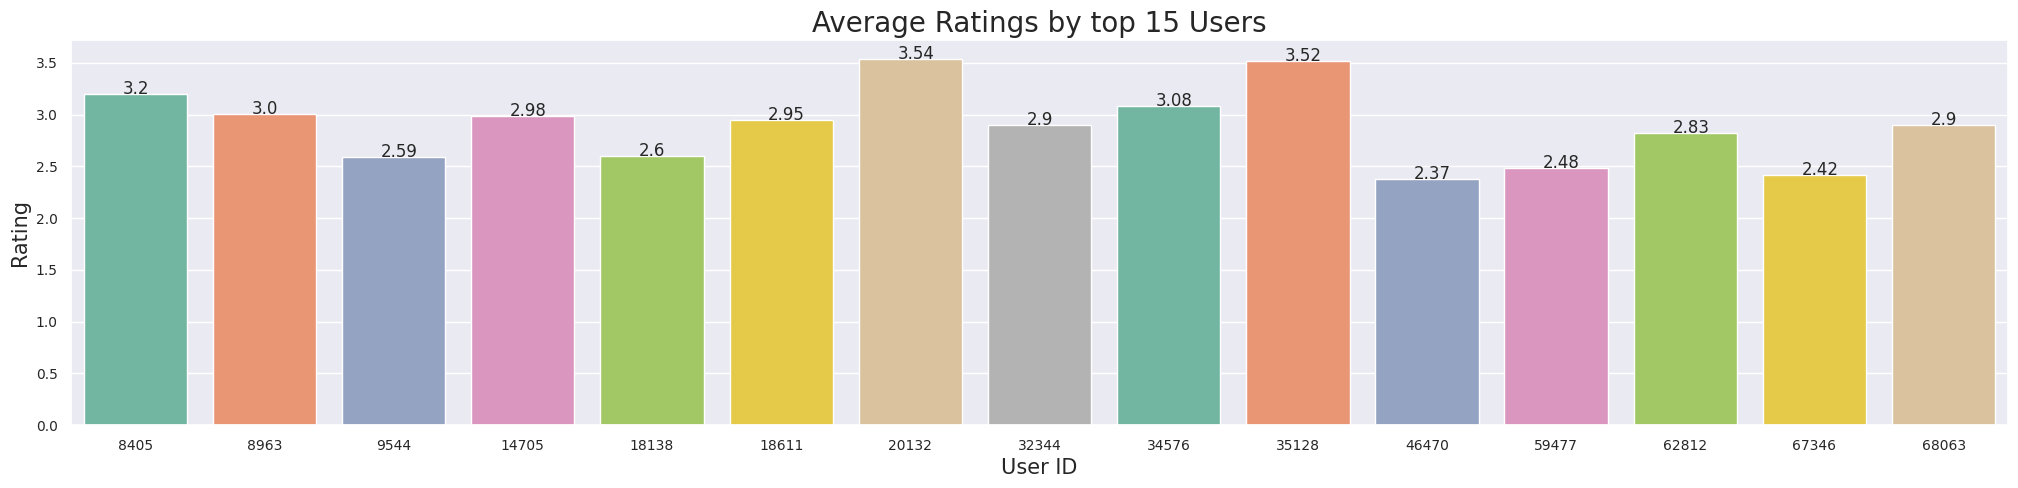

In [46]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="avg_rating", data=avg_ratings_per_user[:15], ax=axes, palette="Set2")

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings by top 15 Users", fontsize = 20)
plt.xlabel("User ID", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

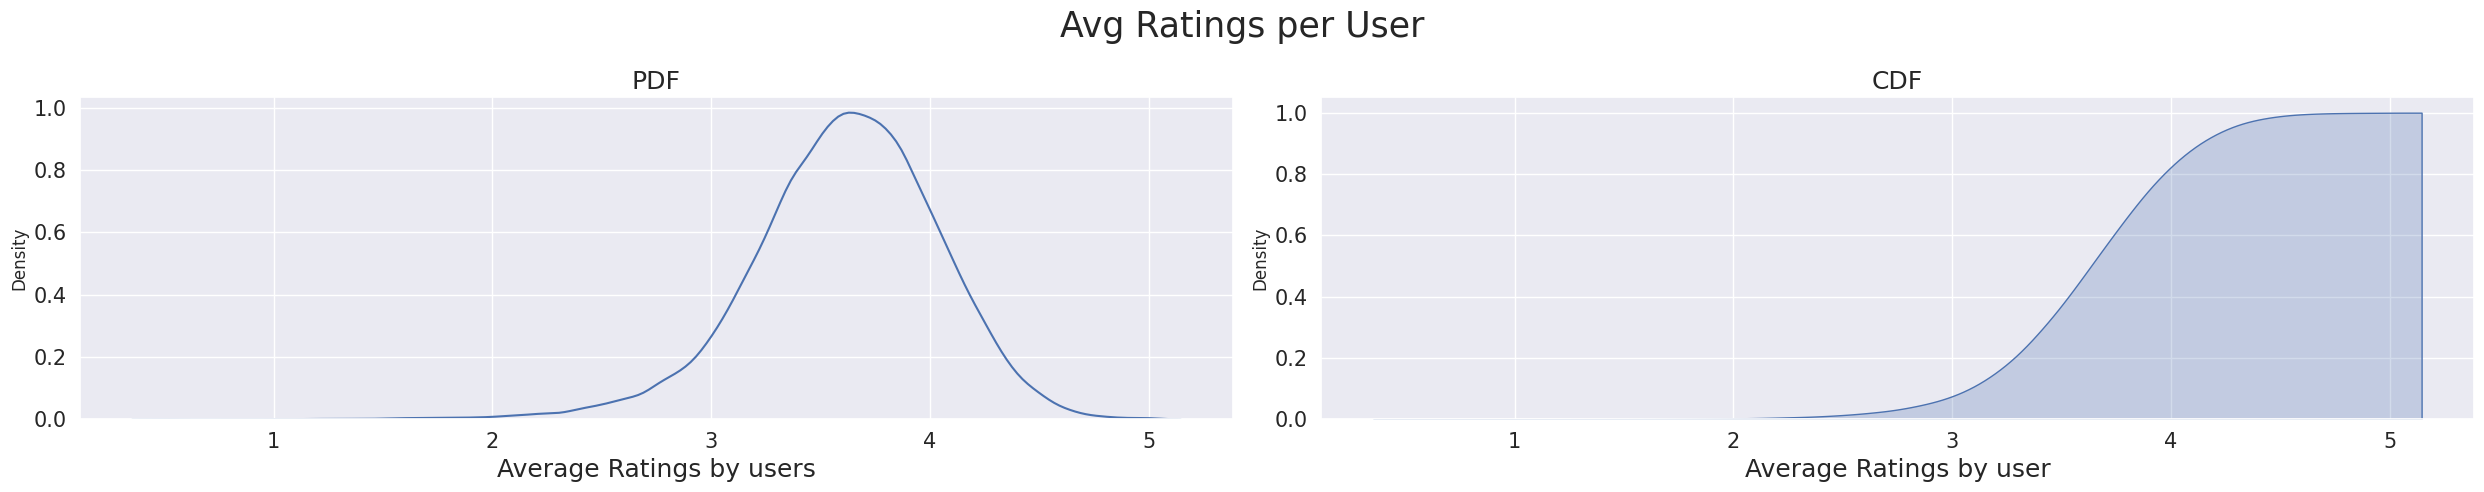

In [47]:
# Plotting the PDF and CDF for Avg. rating by Users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Avg Ratings per User", fontsize=25)

sns.distplot(avg_ratings_per_user["avg_rating"], hist = False, ax = axes[0], label = "PDF")
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Average Ratings by users", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(avg_ratings_per_user["avg_rating"], cumulative = True, ax = axes[1], shade=True, label = "CDF")
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Average Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

Замечания:

1. Идентификатор пользователя 125794 имеет самый высокий средний рейтинг. 3,81.
2. PDF-файл со средними оценками, предоставленный пользователем, кажется немного смещенным влево, при этом большинство значений сосредоточены в пределах от 3,5 до 4.
3. cdf также показывает, что среднее значение. оценки чаще всего находятся в диапазоне от 3 до 5.

---

#####**5. Анализ оценок, выставленных фильмам.**

In [48]:
# Calculating count of ratings received for movies

no_of_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].count().sort_values(by=["rating"], ascending = False)
no_of_ratings_per_movie = no_of_ratings_per_movie.reset_index(drop=True)

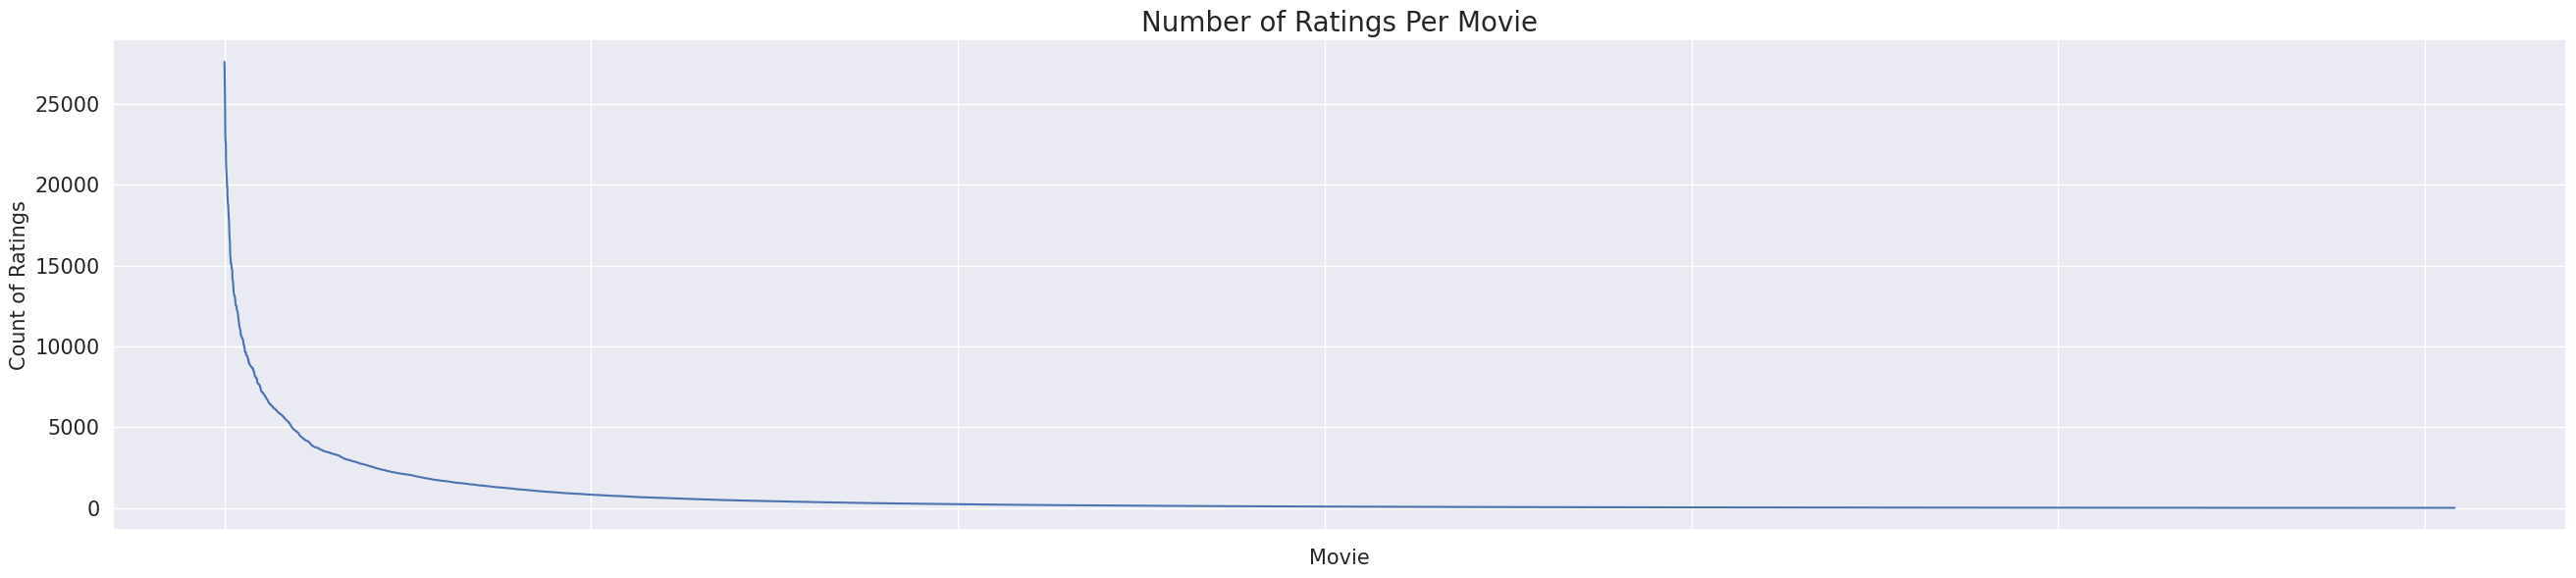

In [49]:
# Visualizing the number of ratings for the movies

sns.set(style="darkgrid")

fig = plt.figure(figsize = (25, 5))
axes = fig.add_axes([0.1, 0.1, 1, 1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.ylabel("Count of Ratings", fontsize = 15)

plt.plot(no_of_ratings_per_movie["rating"].values)

plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

Observations:

1. It is quite clear that there are some movies which are very popular and were rated by many users as comapared to other movies which has caused the plot to be skewed.



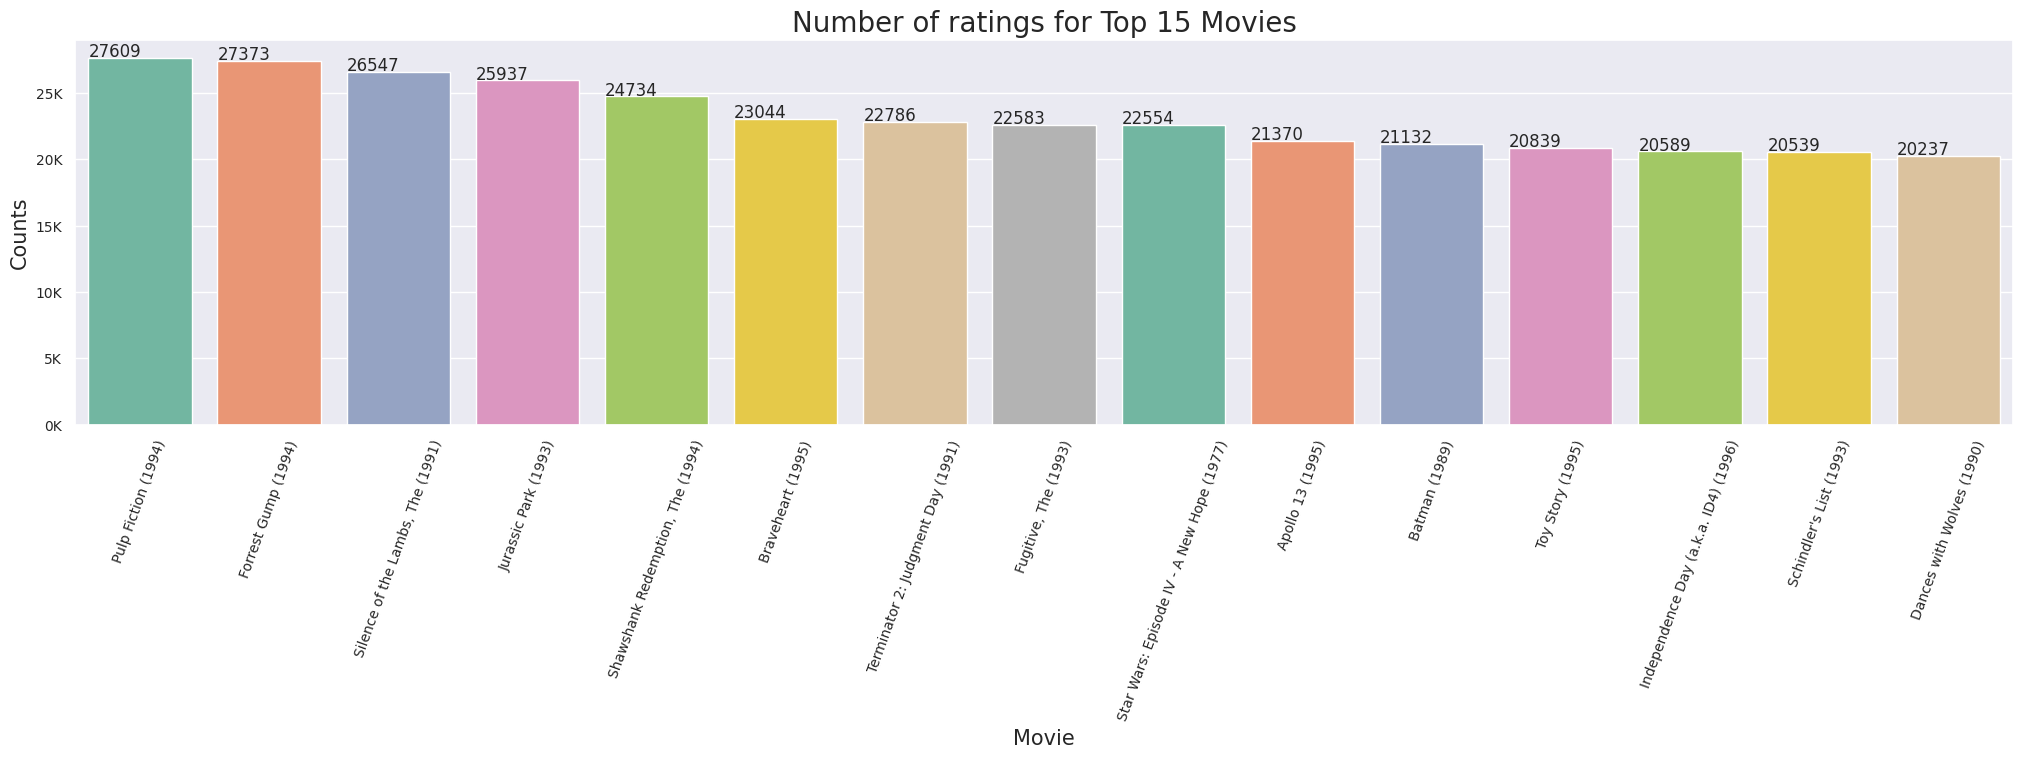

In [50]:
# Visualizing top 5 movies heavily rated movies.

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="rating", data=no_of_ratings_per_movie[:15], ax=axes, palette="Set2")
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Movies", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [51]:
# Calculating average ratings for movies

avg_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].mean()
avg_ratings_per_movie = avg_ratings_per_movie.reset_index(drop=True)
avg_ratings_per_movie = avg_ratings_per_movie.merge(no_of_ratings_per_movie[["movieId", "rating"]], how="left", on="movieId")
avg_ratings_per_movie.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_movie = avg_ratings_per_movie.sort_values("num_of_rating", ascending=False)

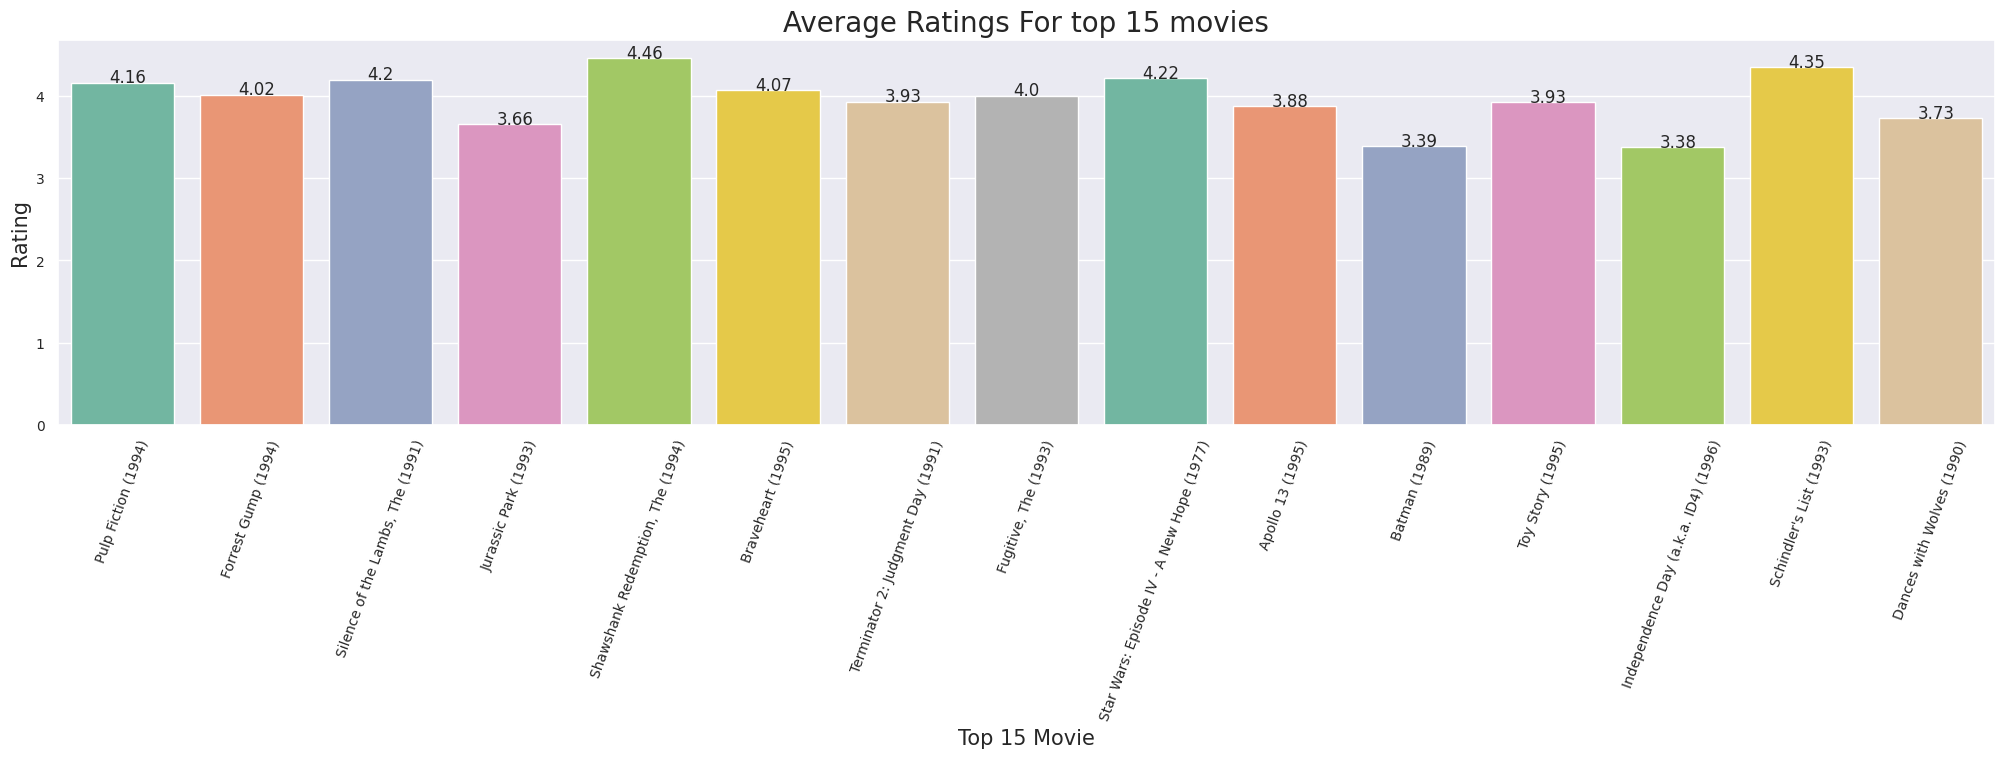

In [52]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="avg_rating", data=avg_ratings_per_movie[:15], ax=axes, palette="Set2")

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings For top 15 movies", fontsize = 20)
plt.xlabel("Top 15 Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

Выводы:

1. Культовые фильмы 1990-х получили наибольшее количество оценок.
2. Криминальное чтиво, Форрест Гамп, Побег из Шоушенка и Молчание ягнят были оценены более 50 тысяч раз.
3. У Shawshank Redemption самый высокий средний рейтинг - 4,46 на основе более чем 50 тысяч оценок.

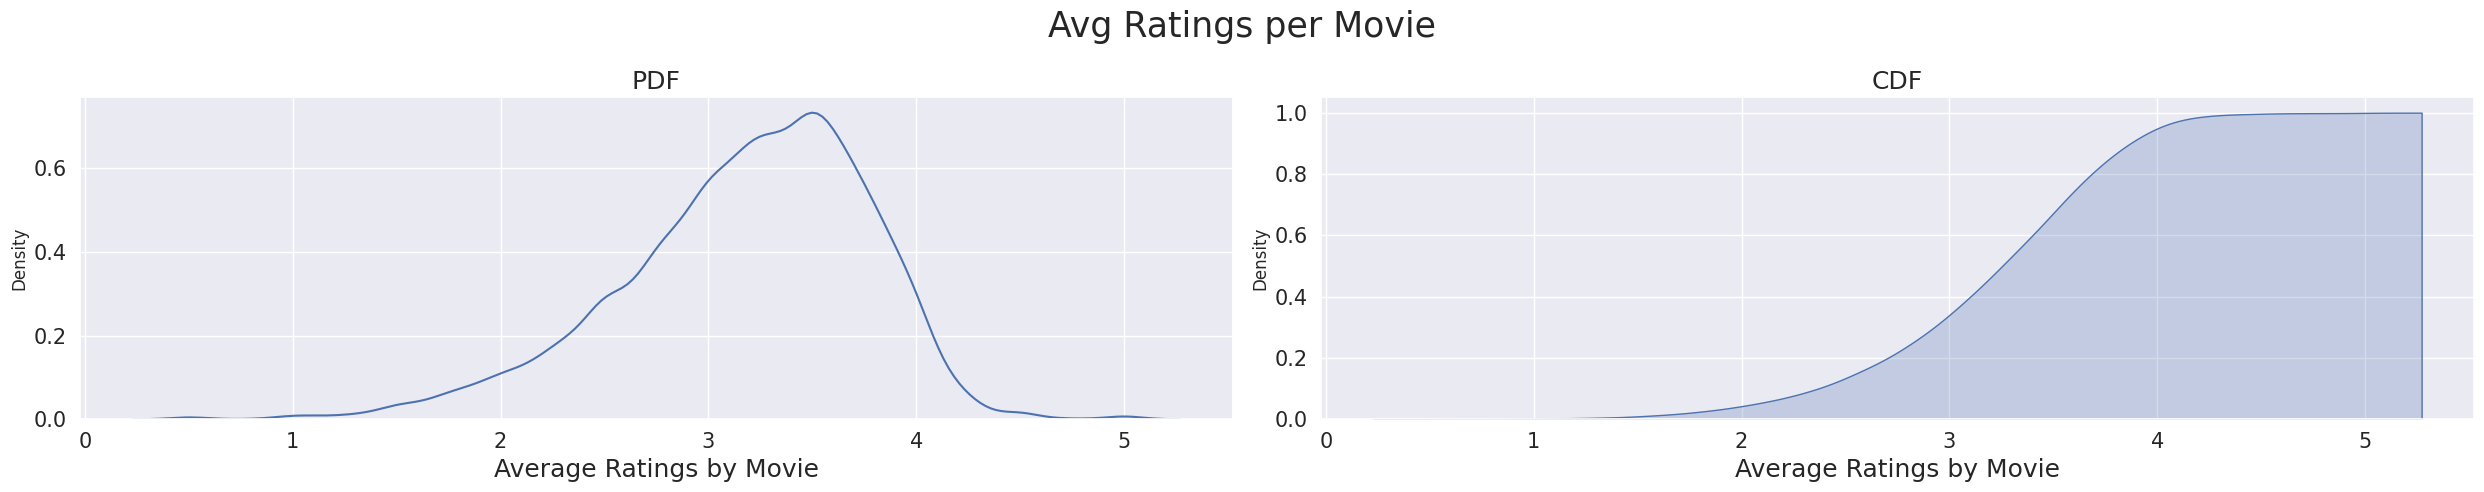

In [53]:
# Plotting the PDF and CDF for Avg. rating by Movies

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Avg Ratings per Movie", fontsize=25)

sns.distplot(avg_ratings_per_movie["avg_rating"], hist = False, ax = axes[0], label = "PDF")
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Average Ratings by Movie", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(avg_ratings_per_movie["avg_rating"], cumulative = True, ax = axes[1], shade=True, label = "CDF")
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Average Ratings by Movie", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

Замечания:

1. Распределение среднего рейтинг для фильма довольно-таки нормальное.
2. cdf показывает, что в СР.Азии. клиентов чаще после 3.

In [54]:
Train_Data.head()

,userId,movieId,rating,date,title,genres,DayOfWeek,Weekday
0,28507,1154,4.0,1995-01-09,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance,Monday,0
1,53434,19,1.0,1996-01-29,Ace Ventura: When Nature Calls (1995),Comedy,Monday,0
2,20821,32,5.0,1996-01-29,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,Monday,0
3,46380,39,5.0,1996-02-02,Clueless (1995),Comedy|Romance,Friday,0
4,46380,52,4.0,1996-02-02,Mighty Aphrodite (1995),Comedy|Drama|Romance,Friday,0


### **3.3. Feature Engineering**

Теперь, когда мы завершили часть исследования данных, мы можем приступить к разработке функций, чтобы подготовить данные для алгоритмов ML.

#### **3.3.1 Создание матриц**

Мы будем создавать матрицы типа: Матрица Пользователь-Элемент, Матрица Пользователь-Пользователь и Матрица Элемент-Элемент.

---

#####**1. Creating USER-ITEM sparse matrix.**

In [55]:
# Path for loading/saving files

file_path = "/content/drive/MyDrive/Colab Notebooks/ML_Python"

In [56]:
# Creating/loading user-movie sparse matrix for train data

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for train Data..")

if os.path.isfile(file_path + "/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz(file_path + "/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
else:
    print("We are creating sparse data..")
    TrainUISparseData = sparse.csr_matrix((Train_Data.rating, (Train_Data.userId, Train_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print("Time taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data..
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Train Sparse matrix = (69140, 14422)
Time taken :  0:00:01.362916


In [57]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.19770308812505% 


In [58]:
# Creating/loading user-movie sparse matrix for test data

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for test Data..")

if os.path.isfile(file_path + "/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz(file_path + "/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix : ", str(TestUISparseData.shape))
else:
    print("We are creating sparse data..")
    TestUISparseData = sparse.csr_matrix((Test_Data.rating, (Test_Data.userId, Test_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz(file_path + "/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print("Time Taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data..
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Test Sparse Matrix :  (69135, 27278)
Time Taken :  0:00:00.597954


In [59]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.89394784364495% 


Выводы:

1. Форма разреженной матрицы зависит от максимального значения userId и максимального значения MovieID.
2. В тестовом наборе немного пользователей из набора train, которого нет в тестовом наборе.
3. Для MovieID в наборе train меньше фильмов по сравнению с тестовым набором. Причина кроется в том факте, что мы разделили данные по времени, и более новые фильмы попали бы в тестовый набор.
4. Разреженность набора поездов составляет 99,19%, в то время как разреженность тестового набора составляет 99,89%.

In [60]:
# Function to Calculate Average rating for users or movies from User-movie sparse matrix

def getAverageRatings(sparseMatrix, if_user):

    #axis = 1 means rows and axis = 0 means columns
    ax = 1 if if_user else 0

    sumOfRatings = sparseMatrix.sum(axis = ax).A1
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}

    return averageRatings

In [61]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users

print("Total no. of Users : ", total_users)
print("No. of Users in Train data : ", train_users)
print("No. of Users not present in Train data : {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users :  69139
No. of Users in Train data :  56127
No. of Users not present in Train data : 13012(19.0%)


In [62]:
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies

print("Total no. of Movies : ", total_movies)
print("No. of Movies in Train data : ", train_movies)
print("No. of Movies not present in Train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies :  23304
No. of Movies in Train data :  12163
No. of Movies not present in Train data = 11141(48.0%)


Выводы:

1. Система рекомендаций страдает от проблем с холодным запуском, которые необходимо решать с умом, чтобы спроектировать эффективную систему.
2. Имеется 23027, т.е. 21% пользователей отсутствуют в обучающих данных.
3. Имеется 12136, т.е. 52% фильмов, которых нет в обучающих данных.

---

#####**2. Создаем матрицу подобия**

Вычисление матрицы подобия пользователь-пользователь или элемент-элемент невозможно, если вычислительная мощность ограничена, учитывая, что у нас есть пользовательский вектор размером 112 тыс. Будет матрица размером 14 тыс. x 14 тыс.

С другой стороны, если мы попытаемся уменьшить размерность, скажем, с помощью усеченного SVD, то это займет еще больше времени, потому что усеченный SVD создает плотную матрицу, и количество умножений для создания матрицы сходства пользователь-пользователь резко возрастет.

В качестве обходного решения мы будем поддерживать двоичный вектор для пользователей, который сообщает нам, вычислили ли мы уже сходство для этого пользователя или нет, или вычислим топ (скажем, 1000) наиболее похожих пользователей для данного пользователя и добавим это в нашу структуру данных, чтобы мы могли просто получить к ней доступ(аналогичных пользователей) без повторного вычисления.

Если он уже вычислен, просто извлеките его непосредственно из нашей структуры данных, в которой есть эта информация. Во время разработки нам, возможно, придется заново вычислять сходства, если они были вычислены давным-давно. Поскольку предпочтения пользователей со временем меняются. Если бы мы могли поддерживать какой-то таймер, который по истечении срока действия должен обновляться (пересчитываться).

Используемая структура данных зависит исключительно от реализации.Одним из простых методов является поддержка словаря словарей:
  - ключ : идентификатор пользователя
  - значение : Снова словарь
       - ключ : _подобный пользователь
       - значение: Значение сходства>

---

**2.1. Вычисление матрицы подобия Item-Item**

In [63]:
# Computing user-user similarity matrix for the train data
# We have 138K sized sparse vectors using which a 14K x 14K movie similarity matrix would be calculated

start = datetime.now()

if not os.path.isfile(file_path + "/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Dimension of Matrix : ", m_m_similarity.shape)
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz(file_path + "/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz(file_path + "/m_m_similarity.npz")
    print("Dimension of Matrix : ", m_m_similarity.shape)

print("The time taken to compute movie-movie similarity matrix is : ", datetime.now() - start)

File exists in the disk. Loading the file...
Dimension of Matrix :  (14422, 14422)
The time taken to compute movie-movie similarity matrix is :  0:00:18.309639


In [64]:
# Creating a function to take Movie Name and generate the top matched name and generate its N similar movies based on M-M Similary

def GetSimilarMoviesUsingMovieMovieSimilarity(movie_name, num_of_similar_movies):
    matches = process.extract(movie_name, movie_list_in_training["title"], scorer=fuzz.partial_ratio)
    if len(matches) == 0:
        return "No Match Found"
    movie_id = movie_list_in_training.iloc[matches[0][2]]["movieId"]
    similar_movie_id_list = np.argsort(-m_m_similarity[movie_id].toarray().ravel())[0:num_of_similar_movies+1]
    sm_df = movie_list_in_training[movie_list_in_training["movieId"].isin(similar_movie_id_list)]
    sm_df["order"] = sm_df.apply(lambda x: list(similar_movie_id_list).index(x["movieId"]), axis=1)

    return sm_df.sort_values("order")

In [65]:
# Picking random movie and checking it's top 10 most similar movies

GetSimilarMoviesUsingMovieMovieSimilarity("Superman", 10)

,movieId,title,genres,order
2515,2556,Superman (1978),Action|Adventure|Sci-Fi,0
2518,2557,Superman II (1980),Action|Sci-Fi,1
2859,2900,RoboCop (1987),Action|Crime|Drama|Sci-Fi|Thriller,2
2768,2831,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,3
1993,2032,Indiana Jones and the Temple of Doom (1984),Action|Adventure|Fantasy,4
1128,1213,"Terminator, The (1984)",Action|Sci-Fi|Thriller,5
1327,1344,Star Trek II: The Wrath of Khan (1982),Action|Adventure|Sci-Fi|Thriller,6
2284,2322,Romancing the Stone (1984),Action|Adventure|Comedy|Romance,7
1860,1928,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,8
1116,1172,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,9


---

**2.2. Computing User-User Similarity Matrix.**



In [66]:
# Getting highest uder id

row_index, col_index = TrainUISparseData.nonzero()
unique_user_id = np.unique(row_index)
print("Max User id is :", np.max(unique_user_id))

Max User id is : 69139


Time elapsed for 20 users = 0:00:05.549868sec
Time elapsed for 40 users = 0:00:11.182392sec
Time elapsed for 60 users = 0:00:16.287599sec
Time elapsed for 80 users = 0:00:21.482809sec
Time elapsed for 100 users = 0:00:26.971205sec
Average Time taken to compute similarity matrix for 1 user = 0.26663608074188233seconds


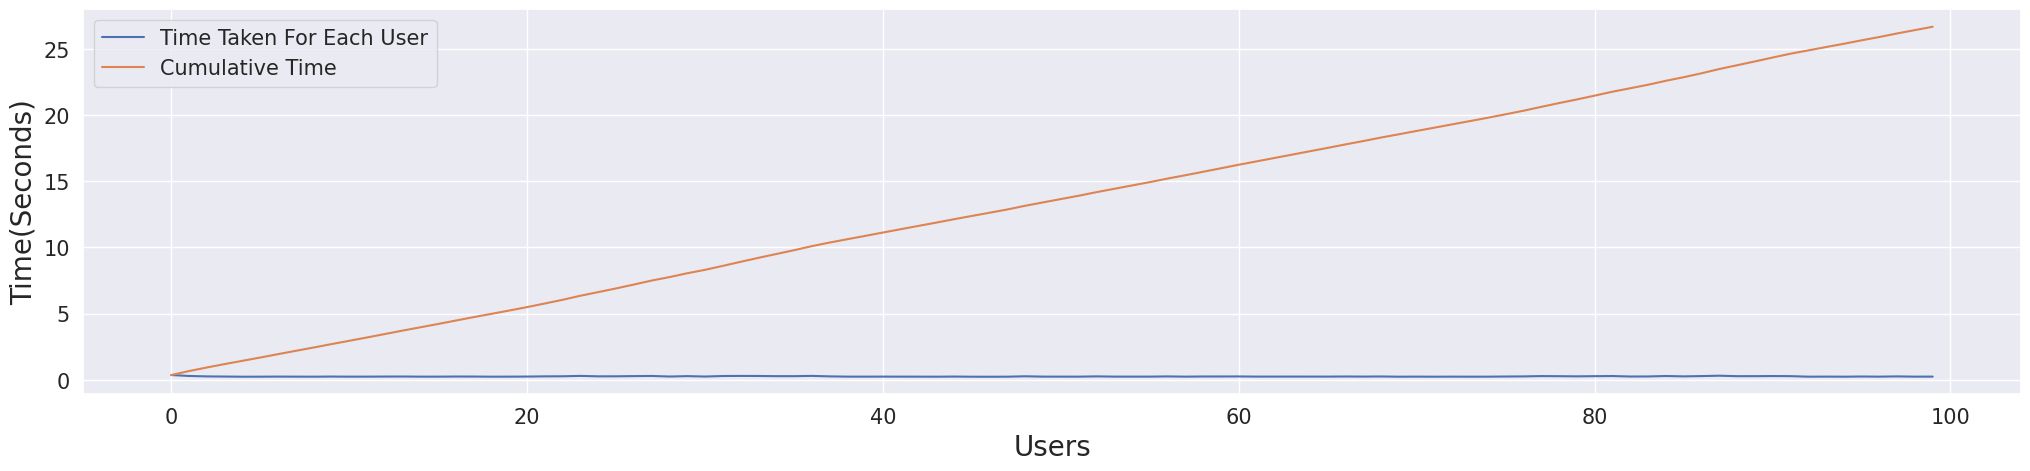

In [67]:
# Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating
# Top 100 most similar users with them.

def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()

    row_index, col_index = sparseMatrix.nonzero()
    rows = np.unique(row_index)
    similarMatrix = np.zeros(13849300).reshape(138493,100)    # 138493*100 = 13849300. As we are building similarity matrix only
    #for top 100 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

    return similarMatrix

simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)

In [68]:
# Calculating user-user similarity only for particular users in our sparse matrix and return user_ids

def Calculate_User_User_Similarity(sparseMatrix, user_id, num_of_similar_users=10):

    if user_id in unique_user_id:
        # Calculating the cosine similarity for user_id with all the "userId"
        sim = cosine_similarity(sparseMatrix.getrow(user_id), sparseMatrix).ravel()
        # Sorting the indexs(user_id) based on the similarity score for all the user ids
        top_similar_user_ids = sim.argsort()[::-1]
        # Sorted the similarity values
        top_similarity_values = sim[top_similar_user_ids]

    return top_similar_user_ids[1: num_of_similar_users+1]

In [69]:
# Getting top 5 users similar to userId: 1

similar_users_1 = Calculate_User_User_Similarity(TrainUISparseData, 1, 5)
similar_users_1

array([62235,  2595, 34101, 42300,  6364])

---

#### **3.3.2 Feature Extraction**

Now we can start extracting meaningful features in order to prepare the data for ML algorithms.

In [70]:
# Path for saving/loading files

file_path = "/content/drive/MyDrive/Colab Notebooks/ML_Python"

In [71]:
# Since the given dataset might not completely fit into computaton capacity that we have, we will sample the data and work it

# Function for Sampling random movies and users to reduce the size of rating matrix
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies, matrix_name):

    np.random.seed(15)   #this will give same random number everytime, without replacement
    startTime = datetime.now()

    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)

    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), shape = (max(userS)+1, max(movieS)+1))

    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(file_path + "/" + matrix_name, sparse_sample)
    print("Shape of Sparse Sampled Matrix = " + str(sparse_sample.shape))
    print("Time taken : ", datetime.now() - startTime)

    return sparse_sample

In [72]:
# Creating Sample Sparse Matrix for Train Data

if not os.path.isfile(file_path + "/TrainUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 5000, 1000, "TrainUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(file_path + "/TrainUISparseData_Sample.npz")
    print("Shape of Train Sample Sparse Matrix = " + str(train_sample_sparse.shape))

File is already present in the disk. Loading the file...
Shape of Train Sample Sparse Matrix = (69114, 14372)


In [73]:
# Creating Sample Sparse Matrix for Test Data

if not os.path.isfile(file_path + "/TestUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200, "TestUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(file_path + "/TestUISparseData_Sample.npz")
    print("Shape of Test Sample Sparse Matrix = " + str(test_sample_sparse.shape))

File is already present in the disk. Loading the file...
Shape of Test Sample Sparse Matrix = (69124, 26106)


In [74]:
# Checking the shape of Training and test data

print("Shape of Train Sparse Matrix : ", train_sample_sparse.shape)
print("Shape of Test Sparse Matrix : ", test_sample_sparse.shape)

Shape of Train Sparse Matrix :  (69114, 14372)
Shape of Test Sparse Matrix :  (69124, 26106)


In [75]:
# Calculating few GlobalAverageRating, AvgMovieRating, AvgUserRating and TotalNoOfRatings

globalAvgRating = np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Global average of all movies ratings in Train Set is : ", globalAvgRating)
print("No. of ratings in the train matrix is : ", train_sample_sparse.count_nonzero())

Global average of all movies ratings in Train Set is :  3.47
No. of ratings in the train matrix is :  53567


In [76]:
# Function to extract features and create row using the sparse matrix

def CreateFeaturesForTrainData(SampledSparseData, TrainSampledSparseData):

    startTime = datetime.now()

    # Extracting userId list, movieId list and Ratings
    sample_users, sample_movies, sample_ratings = sparse.find(SampledSparseData)

    print("No. of rows in the returned dataset : ", len(sample_ratings))

    count = 0
    data = []

    for user, movie, rating in zip(sample_users, sample_movies, sample_ratings):

        row = list()

#----------------------------------Appending "user Id" average, "movie Id" average & global average rating-----------#
        row.append(user)
        row.append(movie)
        row.append(globalAvgRating)

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
        try:
            row.append(globalAvgUsers[user])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise
        try:
            row.append(globalAvgMovies[movie])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
        try:
            similar_users = cosine_similarity(TrainSampledSparseData[user], TrainSampledSparseData).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = TrainSampledSparseData[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
        #########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating]*5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
        try:
            similar_movies = cosine_similarity(TrainSampledSparseData[:,movie].T, TrainSampledSparseData.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = TrainSampledSparseData[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
        ########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating] * 5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Appending rating of "user""movie"-----------#
        row.append(rating)

        count += 1

        data.append(row)

        if count % 5000 == 0:
            print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))

    print("Total Time for {} rows = {}".format(len(data), (datetime.now() - startTime)))
    print("Completed..")
    return data

In [77]:
# Using sampled train data, creating Features for each row and saving it into the list

data_rows = CreateFeaturesForTrainData(train_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  53567
Done for 5000. Time elapsed: 0:01:10.055104
Done for 10000. Time elapsed: 0:02:17.550827
Done for 15000. Time elapsed: 0:03:26.661321
Done for 20000. Time elapsed: 0:04:36.196629
Done for 25000. Time elapsed: 0:05:44.259362
Done for 30000. Time elapsed: 0:06:52.553452
Done for 35000. Time elapsed: 0:08:01.294562
Done for 40000. Time elapsed: 0:09:09.209843
Done for 45000. Time elapsed: 0:10:17.219941
Done for 50000. Time elapsed: 0:11:26.228882
Total Time for 53567 rows = 0:12:13.775734
Completed..


In [78]:
# Using sampled train data, creating Features for each row and saving it into the list

test_data_rows = CreateFeaturesForTrainData(test_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  1920
Total Time for 1920 rows = 0:00:21.565054
Completed..


In [79]:
# Creating the pandas dataframe from the data rows extracted from the sparse matrix for train and test set

names = ["User_ID", "Movie_ID", "Global_Average", "User_Average", "Movie_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "Rating"]
train_regression_data = pd.DataFrame(data_rows, columns=names)
test_regression_data = pd.DataFrame(test_data_rows, columns=names)

In [80]:
# Saving the df to drive for future use

train_regression_data.to_csv(file_path + "/Training_Data_For_Regression.csv")
test_regression_data.to_csv(file_path + "/Testing_Data_For_Regression.csv")

In [81]:
# Loading the train and test csv files

# Path for saving/loading files
file_path = "/content/drive/MyDrive/Colab Notebooks/ML_Python"

print("File is already present in the disk. Loading the file...")

train_regression_data = pd.read_csv(file_path + "/Training_Data_For_Regression.csv")
train_regression_data = train_regression_data.drop(["Unnamed: 0"], axis=1)

test_regression_data = pd.read_csv(file_path + "/Testing_Data_For_Regression.csv")
test_regression_data = test_regression_data.drop(["Unnamed: 0"], axis=1)

print("Done..")

File is already present in the disk. Loading the file...
Done..


In [82]:
# Checking the shape and first few records for train data

print("The shape of the dataframe is : ", train_regression_data.shape)
print("Number of missing Values : ", train_regression_data.isnull().sum().sum())
train_regression_data.head()

The shape of the dataframe is :  (53567, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,16,899,3.47,3.428571,3.903226,3.0,4.5,5.0,4.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0
1,16,1529,3.47,3.428571,3.558418,4.0,4.0,4.0,4.0,5.0,3.0,4.0,3.0,3.0,2.0,4.0
2,16,2017,3.47,3.428571,3.223831,3.0,4.0,4.0,5.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0
3,16,2674,3.47,3.428571,3.225000,2.0,4.0,5.0,4.0,1.0,3.0,4.0,3.0,4.0,3.0,2.0
4,16,2706,3.47,3.428571,3.796143,5.0,5.0,4.0,4.5,4.0,3.0,4.0,3.0,3.0,2.0,4.0


In [83]:
# Checking the shape and first few records for test data

print("The shape of the dataframe is : ", test_regression_data.shape)
print("Number of missing Values : ", test_regression_data.isnull().sum().sum())
test_regression_data.head()

The shape of the dataframe is :  (1920, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,383,4953,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,2.0
1,383,6430,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.5
2,485,6430,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.0
3,520,1970,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,4.5
4,520,15641,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,4.5


Вывод:

Описание фич приведено ниже:
1. User_ID: Идентификатор этого пользователя
2. Movie_ID: идентификатор этого фильма
3. Global_Average: Средний рейтинг по всему миру
4. User_Average: Средний рейтинг этого пользователя
5. Movie_Average: Средняя оценка этого фильма
6. Оценки, данные этому фильму топ-5 пользователями, похожими на этого пользователя: (SUR1, SUR2, SUR3, SUR4, sur5)
11. Рейтинг, который этот Пользователь присвоил топ-5 фильмам, похожим на этот фильм: (SMR1, SMR2, SMR3, SMR4, SMR5)
16. Рейтинг: Рейтинг, который этот Пользователь присвоил этому фильму



**Преобразование данных для Surprise Models**

Преобразование обучающих данных:

Мы не можем предоставить исходные данные (фильм, пользователя, рейтинг) для обучения модели в библиотеке Surprise. У них есть отдельный формат для данных о поездах и тестах, который будет полезен для обучения таких моделей, как SVD, KNN, BaseLineOnly и т.д., в Surprise.

Мы можем сформировать набор поездов из файла или из фрейма данных Pandas. http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

Преобразование тестовых данных:

Для тестовых данных нам просто нужно определить кортеж (пользователь, элемент, рейтинг).
Ознакомьтесь с этой ссылкой: https://github.com/NicolasHug/Surprise/commit/86cf44529ca0bbb97759b81d1716ff547b950812

Приведенная выше ссылка - это библиотека сюрпризов на github. Проверьте методы "def all_ratings(self)" и "def build_testset(self)" со строк 177 по 201 (если они изменяют файл, номер строки может отличаться, но вы всегда можете проверить вышеупомянутые два метода).
метод "def build_test set(self)" возвращает список кортежей (пользователь, элемент, рейтинг).


In [84]:
train_regression_data[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,16,899,3.0
1,16,1529,4.0
2,16,2017,3.0
3,16,2674,2.0
4,16,2706,4.0


In [85]:
# Using Surprise library Data Structures to store train data

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_regression_data[["User_ID", "Movie_ID", "Rating"]], reader)
trainset = data.build_full_trainset()

In [86]:
# Creating tuple for test set

testset = list(zip(test_regression_data["User_ID"].values, test_regression_data["Movie_ID"].values, test_regression_data["Rating"].values))

---

## **4. Model Buliding**

Мы попытаемся построить регрессионную модель, чтобы предсказать оценку, которую пользователь дает фильму, на основе сгенерированных характеристик.

У нас есть две метрики ошибок:

  - RMSE: среднеквадратичная ошибка: RMSE - это ошибка для каждой точки, которая возводится в квадрат. Затем вычисляется среднее значение. Наконец, в качестве конечного значения берется корень из этого среднего значения.

  - MAPE: Абсолютная процентная ошибка среднего значения: Средняя абсолютная процентная ошибка (MAPE), также известная как среднее абсолютное процентное отклонение (MAPD), является мерой точности прогноза метода прогнозирования.

    Разница между At и Ft снова делится на фактическое значение At. Абсолютное значение в этом расчете суммируется для каждого прогнозируемого момента времени и делится на количество подходящих точек n. Умножение на 100% приводит к процентной погрешности.

    где At - фактическое значение, а Ft - прогнозируемое значение.

In [87]:
# Utilities to save the modelling results

error_cols = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]
error_table = pd.DataFrame(columns = error_cols)
model_train_evaluation = dict()
model_test_evaluation = dict()

In [88]:
# Function to save modelling results in a table

def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    # Создание нового DataFrame с результатами
    new_row = pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns=error_cols)
    # Использование pd.concat для добавления новой строки
    error_table = pd.concat([error_table, new_row], ignore_index=True)

In [89]:
# Function to calulate RMSE and MAPE values

def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [90]:
# Apply Xgboost Regressor on the Train and Test Data

def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):

    startTime = datetime.now()
    train_result = dict()
    test_result = dict()

    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)

    print("-" * 50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE : {}".format(rmse_train))
    print("MAPE : {}".format(mape_train))
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}

    print("-" * 50)
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE : {}".format(rmse_test))
    print("MAPE : {}".format(mape_test))
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}

    print("-"*50)
    print("Time Taken : ", datetime.now() - startTime)

    plot_importance(clf)
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)

    return train_result, test_result

# Function to plot feature importance for a model

def plot_importance(clf):

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    ax = fig.add_axes([0, 0, 1, 1])

    xgb.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

In [91]:
# in surprise prediction of every data point is returned as dictionary like this:
# "user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
# In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [92]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# Running Surprise model algorithms
def run_surprise(algo, trainset, testset, model_name):

    startTime = datetime.now()

    train = dict()
    test = dict()

    algo.fit(trainset)

#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}

#-----------------Evaluating Test Data------------------#
    print("-"*50)
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    print("-"*50)
    print("Time Taken = "+str(datetime.now() - startTime))

    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)

    return train, test

### **4.1 Разделение на train/test**

Мы можем разделить данные для обучения / тестирования и выделить независимые и зависимые функции.

In [93]:
# Creating the train-test X and y variables for the ML algos

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

### **4.2 Обучение модели**

Обучение различных моделей и сравнение по их метрикам.


--------------------------------------------------
TRAIN DATA
RMSE : 0.7003611762836592
MAPE : 22.126592395440113
--------------------------------------------------
TEST DATA
RMSE : 1.000999214532469
MAPE : 35.57922282038384
--------------------------------------------------
Time Taken :  0:00:00.892125


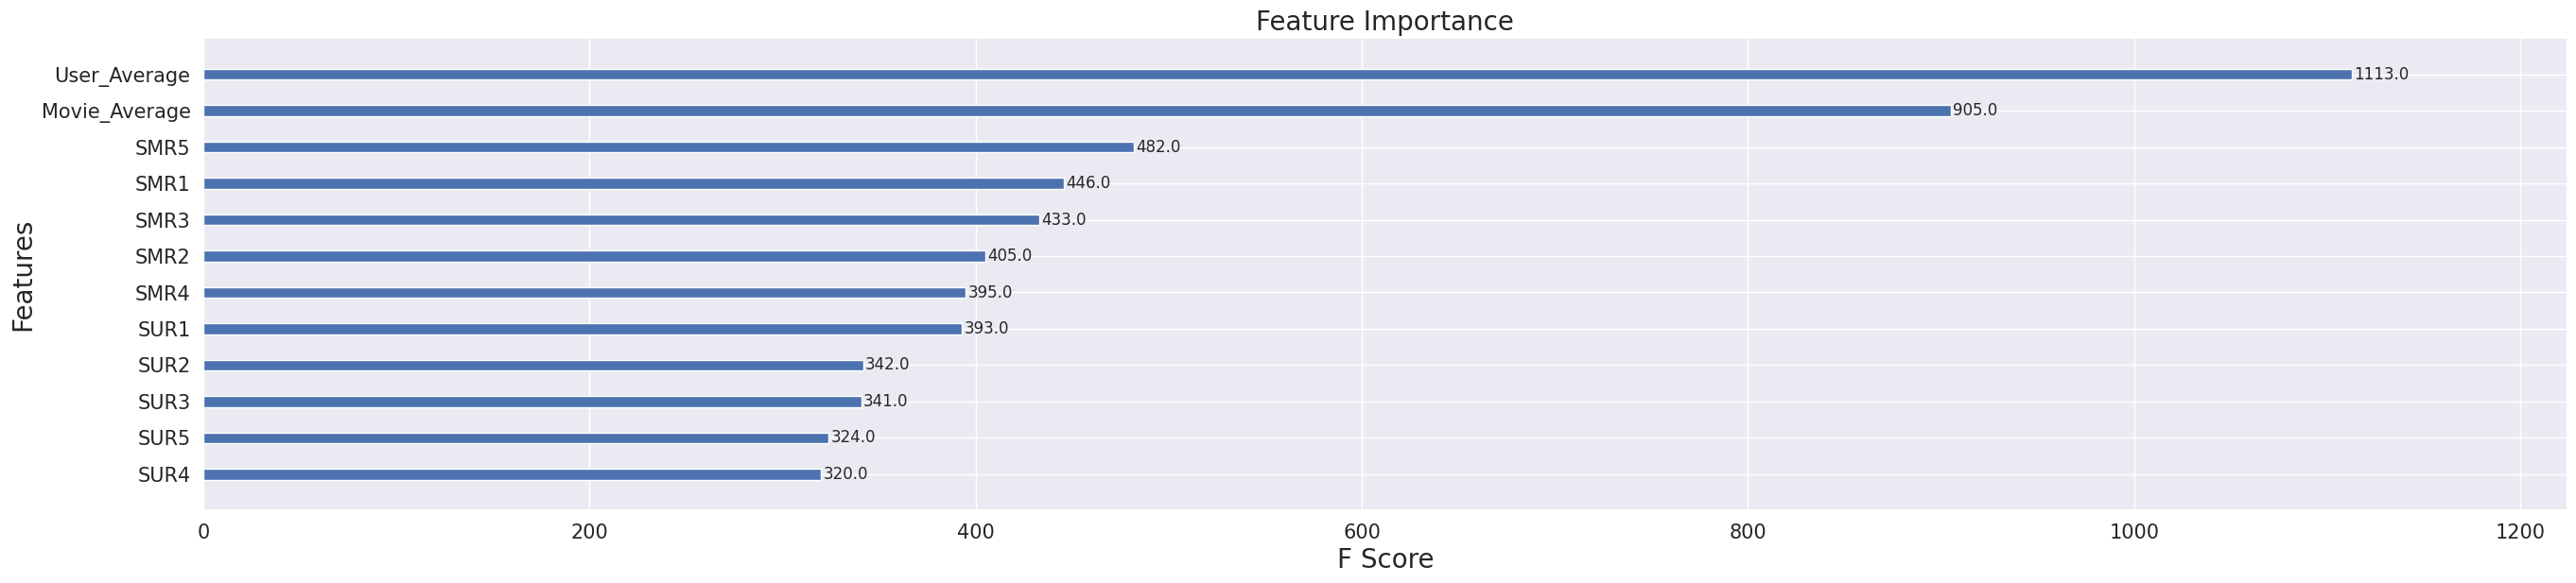

In [94]:
# Training the Xgboost Regression Model on with the 13 features

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

# Инициализация DataFrame, если они еще не инициализированы
model_train_evaluation = pd.DataFrame()
model_test_evaluation = pd.DataFrame()

# Обновление оценок моделей
model_train_evaluation = pd.concat([model_train_evaluation, pd.DataFrame({'XGBoost_13': [train_result]})], ignore_index=True)
model_test_evaluation = pd.concat([model_test_evaluation, pd.DataFrame({'XGBoost_13': [test_result]})], ignore_index=True)

Выводы:

1. "User_Average", безусловно, является наиболее важной функцией для прогнозирования рейтинга.
2. "Movie_Average" - вторая по важности функция для прогнозирования рейтингов.
3. Топ-5 похожих пользовательских рейтингов и топ-5 похожих рейтингов фильмов, по-видимому, не являются эффективными функциями.

In [95]:
# Applying BaselineOnly from the surprise library to predict the ratings

bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8232230473397145
MAPE = 27.82945142340065
--------------------------------------------------
TEST DATA
RMSE = 1.0011429118402315
MAPE = 35.54069061262532
--------------------------------------------------
Time Taken = 0:00:00.525169


In [96]:
predictions_train = train_result["Prediction"]
predictions_test = test_result["Prediction"]

In [97]:
# Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

train_regression_data["BaselineOnly"] = predictions_train
test_regression_data["BaselineOnly"] = predictions_test

In [98]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,16,899,3.47,3.428571,3.903226,3.0,4.5,5.0,4.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.710418
1,16,1529,3.47,3.428571,3.558418,4.0,4.0,4.0,4.0,5.0,3.0,4.0,3.0,3.0,2.0,4.0,3.386714
2,16,2017,3.47,3.428571,3.223831,3.0,4.0,4.0,5.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0,3.078817
3,16,2674,3.47,3.428571,3.225000,2.0,4.0,5.0,4.0,1.0,3.0,4.0,3.0,4.0,3.0,2.0,3.137717
4,16,2706,3.47,3.428571,3.796143,5.0,5.0,4.0,4.5,4.0,3.0,4.0,3.0,3.0,2.0,4.0,3.670831


In [99]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,383,4953,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,2.0,3.469421
1,383,6430,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.5,3.469421
2,485,6430,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.0,3.469421
3,520,1970,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,4.5,3.469421
4,520,15641,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,4.5,3.469421


--------------------------------------------------
TRAIN DATA
RMSE : 0.6898029573058597
MAPE : 21.736752871852126
--------------------------------------------------
TEST DATA
RMSE : 1.0011916226346014
MAPE : 36.229774765512616
--------------------------------------------------
Time Taken :  0:00:00.763871


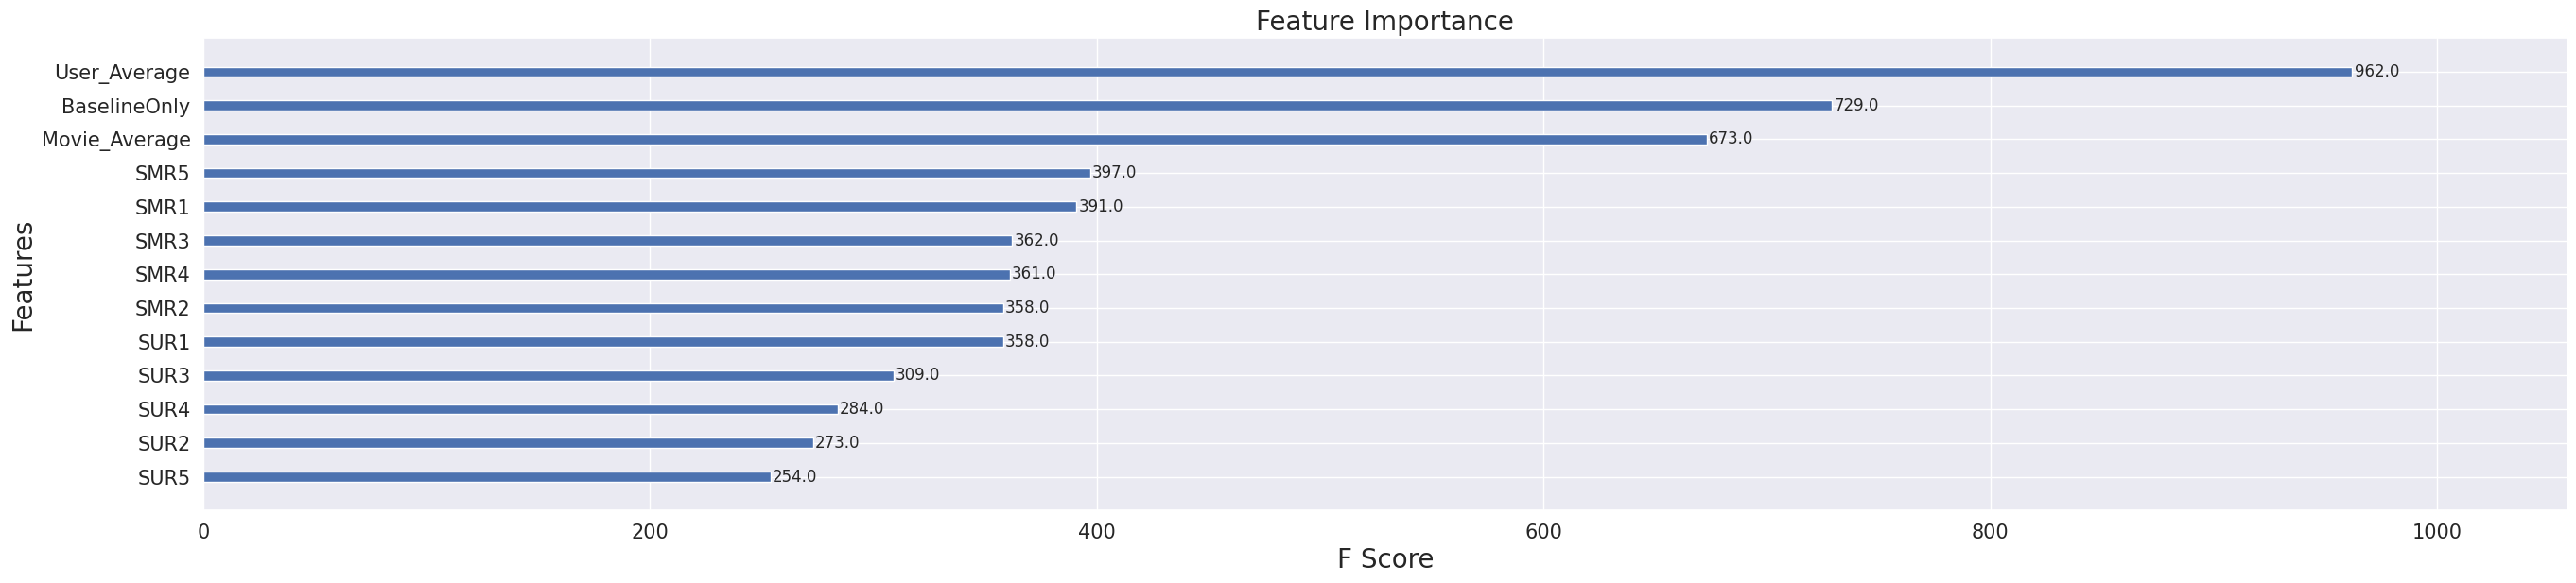

In [100]:
# Fitting the Xgboost again with new BaselineOnly feature

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

In [101]:
# Finding the suitable parameter for Surprise KNN-Baseline with User-User Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [102]:
# Applying the KNN-Baseline with the searched parameters

sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3279157085828237
MAPE = 10.095417929995154
--------------------------------------------------
TEST DATA
RMSE = 1.0010300586014307
MAPE = 35.55471027019784
--------------------------------------------------
Time Taken = 0:00:47.290204


In [103]:
# Similarly finding best parameters for Surprise KNN-Baseline with Item-Item Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [104]:
# Applying KNN-Baseline with best parameters searched

sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.2692119763387241
MAPE = 8.005491746485227
--------------------------------------------------
TEST DATA
RMSE = 1.0010068482653236
MAPE = 35.55411417841919
--------------------------------------------------
Time Taken = 0:00:03.028597


In [105]:
print("Train Result Type:", type(train_result))
print("Test Result Type:", type(test_result))

print("Train Result Content:", train_result)
print("Test Result Content:", test_result)

Train Result Type: <class 'dict'>
Test Result Type: <class 'dict'>
Train Result Content: {'RMSE': 0.2692119763387241, 'MAPE': 8.005491746485227, 'Prediction': array([3.24474688, 3.79327408, 2.92873237, ..., 4.50545289, 4.95399886,
       4.97334653])}
Test Result Content: {'RMSE': 1.0010068482653236, 'MAPE': 35.55411417841919, 'Prediction': array([3.46942147, 3.46942147, 3.46942147, ..., 3.46942147, 3.46942147,
       3.46942147])}


In [106]:
predictions_train = train_result["Prediction"]
predictions_test = test_result["Prediction"]

In [107]:
# Addding the KNNBaseline features to the train and test dataset

train_regression_data["KNNBaseline_User"] = predictions_train
train_regression_data["KNNBaseline_Item"] = predictions_train

test_regression_data["KNNBaseline_User"] = predictions_test
test_regression_data["KNNBaseline_Item"] = predictions_test

In [108]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,16,899,3.47,3.428571,3.903226,3.0,4.5,5.0,4.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.710418,3.244747,3.244747
1,16,1529,3.47,3.428571,3.558418,4.0,4.0,4.0,4.0,5.0,3.0,4.0,3.0,3.0,2.0,4.0,3.386714,3.793274,3.793274
2,16,2017,3.47,3.428571,3.223831,3.0,4.0,4.0,5.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0,3.078817,2.928732,2.928732
3,16,2674,3.47,3.428571,3.225000,2.0,4.0,5.0,4.0,1.0,3.0,4.0,3.0,4.0,3.0,2.0,3.137717,2.171098,2.171098
4,16,2706,3.47,3.428571,3.796143,5.0,5.0,4.0,4.5,4.0,3.0,4.0,3.0,3.0,2.0,4.0,3.670831,3.784185,3.784185


In [109]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,383,4953,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,2.0,3.469421,3.469421,3.469421
1,383,6430,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.5,3.469421,3.469421,3.469421
2,485,6430,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.0,3.469421,3.469421,3.469421
3,520,1970,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,4.5,3.469421,3.469421,3.469421
4,520,15641,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,4.5,3.469421,3.469421,3.469421


--------------------------------------------------
TRAIN DATA
RMSE : 0.13627700964354816
MAPE : 3.236946958812221
--------------------------------------------------
TEST DATA
RMSE : 1.0000359865876085
MAPE : 35.833312142758615
--------------------------------------------------
Time Taken :  0:00:00.854307


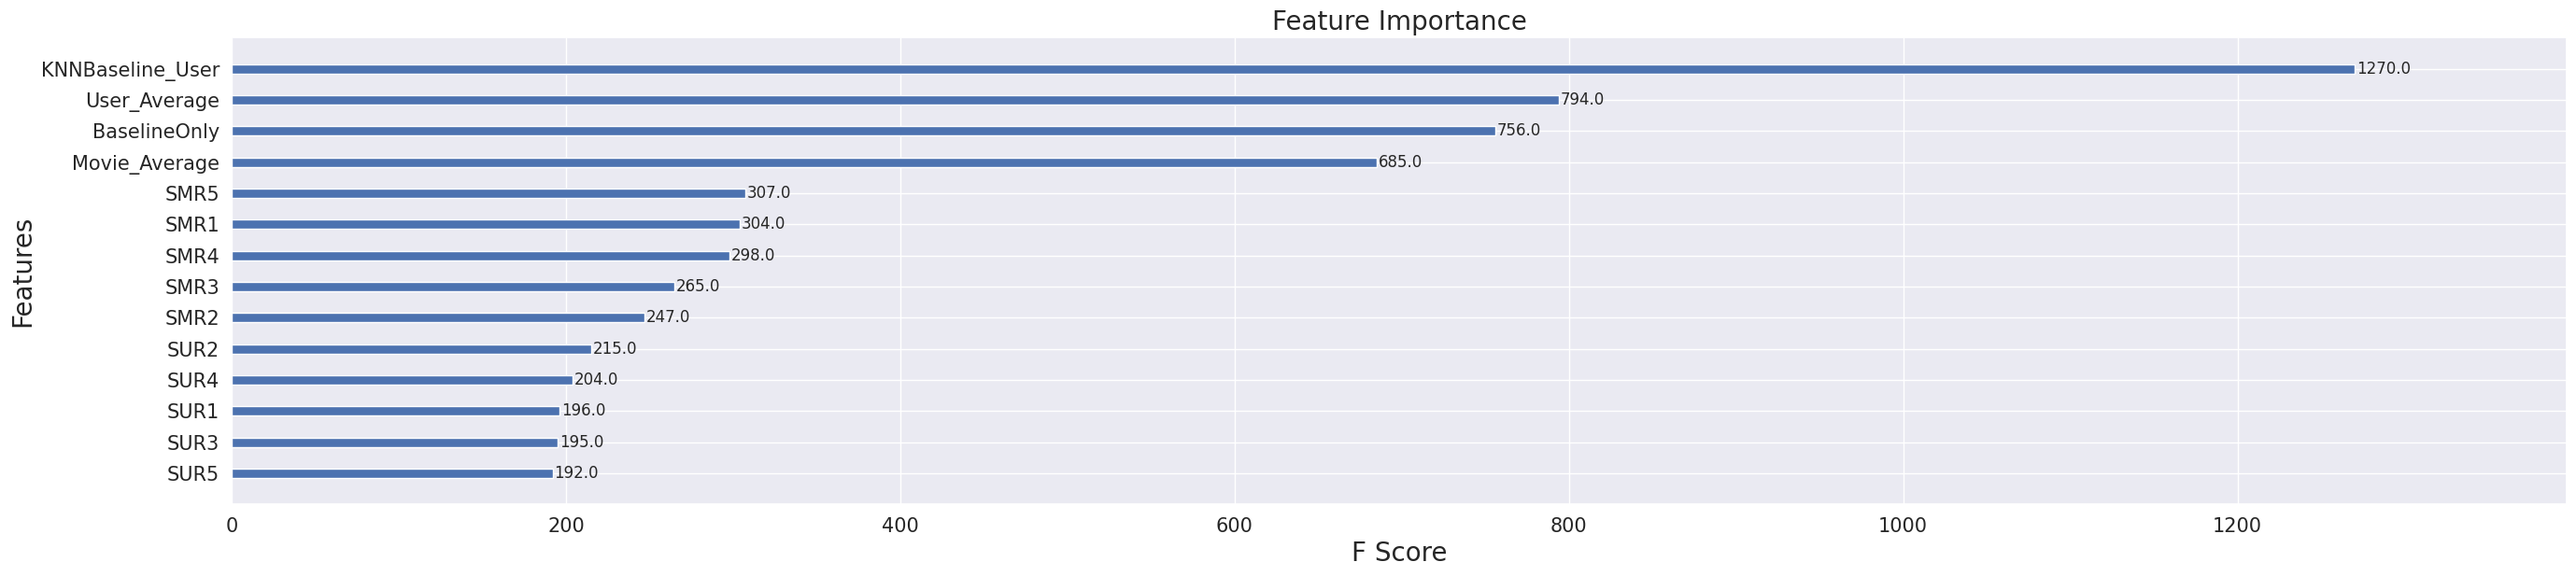

In [110]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

Observations:

1. The KNN Baseline features are also not an effective predictor.

In [111]:
# Appling the SlopeOne algorithm from the Surprise library

so = SlopeOne()

train_result, test_result = run_surprise(so, trainset, testset, "SlopeOne")

model_train_evaluation["SlopeOne"] = train_result
model_test_evaluation["SlopeOne"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE = 0.754607945596036
MAPE = 24.558562019285045
--------------------------------------------------
TEST DATA
RMSE = 1.0024479205452683
MAPE = 35.59940796956004
--------------------------------------------------
Time Taken = 0:00:01.595404


In [112]:
predictions_train = train_result["Prediction"]
predictions_test = test_result["Prediction"]

In [113]:
# Adding the SlopOne predictions to the train and test datasets

train_regression_data["SlopeOne"] = predictions_train
train_regression_data["SlopeOne"] = predictions_train

test_regression_data["SlopeOne"] = predictions_test
test_regression_data["SlopeOne"] = predictions_test

In [114]:
# Matrix Factorization using SVD from Surprise Library

# here, n_factors is the equivalent to dimension 'd' when matrix 'A'
# is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8999762989873225
{'n_factors': 5}


In [115]:
# Applying SVD with best parameters

algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8297683579076948
MAPE = 28.388505040424523
--------------------------------------------------
TEST DATA
RMSE = 1.0009518548037237
MAPE = 35.551926688015186
--------------------------------------------------
Time Taken = 0:00:00.909627


In [116]:
# Matrix Factorization SVDpp with implicit feedback

# Hyper-parameter optimization for SVDpp
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8940306125424536
{'n_factors': 10, 'lr_all': 0.006}


In [117]:
#Applying SVDpp with best parameters¶

algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.773559399984891
MAPE = 26.1353361271466
--------------------------------------------------
TEST DATA
RMSE = 1.0009408990974218
MAPE = 35.54864677530869
--------------------------------------------------
Time Taken = 0:00:06.420452


In [118]:
predictions_train = train_result["Prediction"]
predictions_test = test_result["Prediction"]

In [119]:
# XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

train_regression_data["SVD"] = predictions_train
train_regression_data["SVDpp"] = predictions_train

test_regression_data["SVD"] = predictions_test
test_regression_data["SVDpp"] = predictions_test

In [120]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVD,SVDpp
0,16,899,3.47,3.428571,3.903226,3.0,4.5,5.0,4.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.710418,3.244747,3.244747,3.553838,3.709404,3.709404
1,16,1529,3.47,3.428571,3.558418,4.0,4.0,4.0,4.0,5.0,3.0,4.0,3.0,3.0,2.0,4.0,3.386714,3.793274,3.793274,3.346946,3.472259,3.472259
2,16,2017,3.47,3.428571,3.223831,3.0,4.0,4.0,5.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0,3.078817,2.928732,2.928732,3.100902,2.913887,2.913887
3,16,2674,3.47,3.428571,3.225000,2.0,4.0,5.0,4.0,1.0,3.0,4.0,3.0,4.0,3.0,2.0,3.137717,2.171098,2.171098,2.859730,3.170218,3.170218
4,16,2706,3.47,3.428571,3.796143,5.0,5.0,4.0,4.5,4.0,3.0,4.0,3.0,3.0,2.0,4.0,3.670831,3.784185,3.784185,3.641843,3.518229,3.518229


In [121]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVD,SVDpp
0,383,4953,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,2.0,3.469421,3.469421,3.469421,3.469421,3.469421,3.469421
1,383,6430,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.5,3.469421,3.469421,3.469421,3.469421,3.469421,3.469421
2,485,6430,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.0,3.469421,3.469421,3.469421,3.469421,3.469421,3.469421
3,520,1970,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,4.5,3.469421,3.469421,3.469421,3.469421,3.469421,3.469421
4,520,15641,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,3.47,4.5,3.469421,3.469421,3.469421,3.469421,3.469421,3.469421


In [122]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [123]:
import catboost as catb

In [124]:
def train_test_catboost(x_train, x_test, y_train, y_test, model_name):

    startTime = datetime.now()
    train_result = dict()
    test_result = dict()

    clf = catb.CatBoostRegressor(n_estimators=100, verbose=1, thread_count=10)
    clf.fit(x_train, y_train)

    print("-" * 50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE : {}".format(rmse_train))
    print("MAPE : {}".format(mape_train))
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}

    print("-" * 50)
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE : {}".format(rmse_test))
    print("MAPE : {}".format(mape_test))
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}

    print("-"*50)
    print("Time Taken : ", datetime.now() - startTime)

    # plot_importance(clf)
    #catb.get_feature_importance(catb, clf)
    #make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)

    return train_result, test_result

In [125]:
train_result, test_result = train_test_catboost(x_train, x_test, y_train, y_test, "CatBoost")

model_train_evaluation["CatBoost"] = train_result
model_test_evaluation["CatBoost"] = test_result


Learning rate set to 0.499281
0:	learn: 0.5880153	total: 59.7ms	remaining: 5.91s
1:	learn: 0.3688133	total: 69.8ms	remaining: 3.42s
2:	learn: 0.2668815	total: 80ms	remaining: 2.59s
3:	learn: 0.2287928	total: 89.7ms	remaining: 2.15s
4:	learn: 0.2129938	total: 100ms	remaining: 1.9s
5:	learn: 0.2047898	total: 110ms	remaining: 1.72s
6:	learn: 0.2004936	total: 124ms	remaining: 1.65s
7:	learn: 0.1974279	total: 133ms	remaining: 1.53s
8:	learn: 0.1940214	total: 144ms	remaining: 1.46s
9:	learn: 0.1929745	total: 154ms	remaining: 1.38s
10:	learn: 0.1913309	total: 164ms	remaining: 1.33s
11:	learn: 0.1902565	total: 174ms	remaining: 1.27s
12:	learn: 0.1886936	total: 184ms	remaining: 1.23s
13:	learn: 0.1878494	total: 197ms	remaining: 1.21s
14:	learn: 0.1869868	total: 206ms	remaining: 1.17s
15:	learn: 0.1861209	total: 228ms	remaining: 1.2s
16:	learn: 0.1853331	total: 251ms	remaining: 1.23s
17:	learn: 0.1845306	total: 305ms	remaining: 1.39s
18:	learn: 0.1842356	total: 353ms	remaining: 1.51s
19:	learn: 

In [126]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "Catboost")

model_train_evaluation["Catboost"] = train_result
model_test_evaluation["Catboost"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8232230473397145
MAPE = 27.82945142340065
--------------------------------------------------
TEST DATA
RMSE = 1.0011429118402315
MAPE = 35.54069061262532
--------------------------------------------------
Time Taken = 0:00:00.887620


In [127]:
predictions_train = train_result["Prediction"]
predictions_test = test_result["Prediction"]

In [128]:
train_regression_data["Catboost"] = predictions_train
test_regression_data["Catboost"] = predictions_test

--------------------------------------------------
TRAIN DATA
RMSE : 0.13109812256173542
MAPE : 3.1079880540757268
--------------------------------------------------
TEST DATA
RMSE : 1.000234567514503
MAPE : 35.895619576343556
--------------------------------------------------
Time Taken :  0:00:10.472251


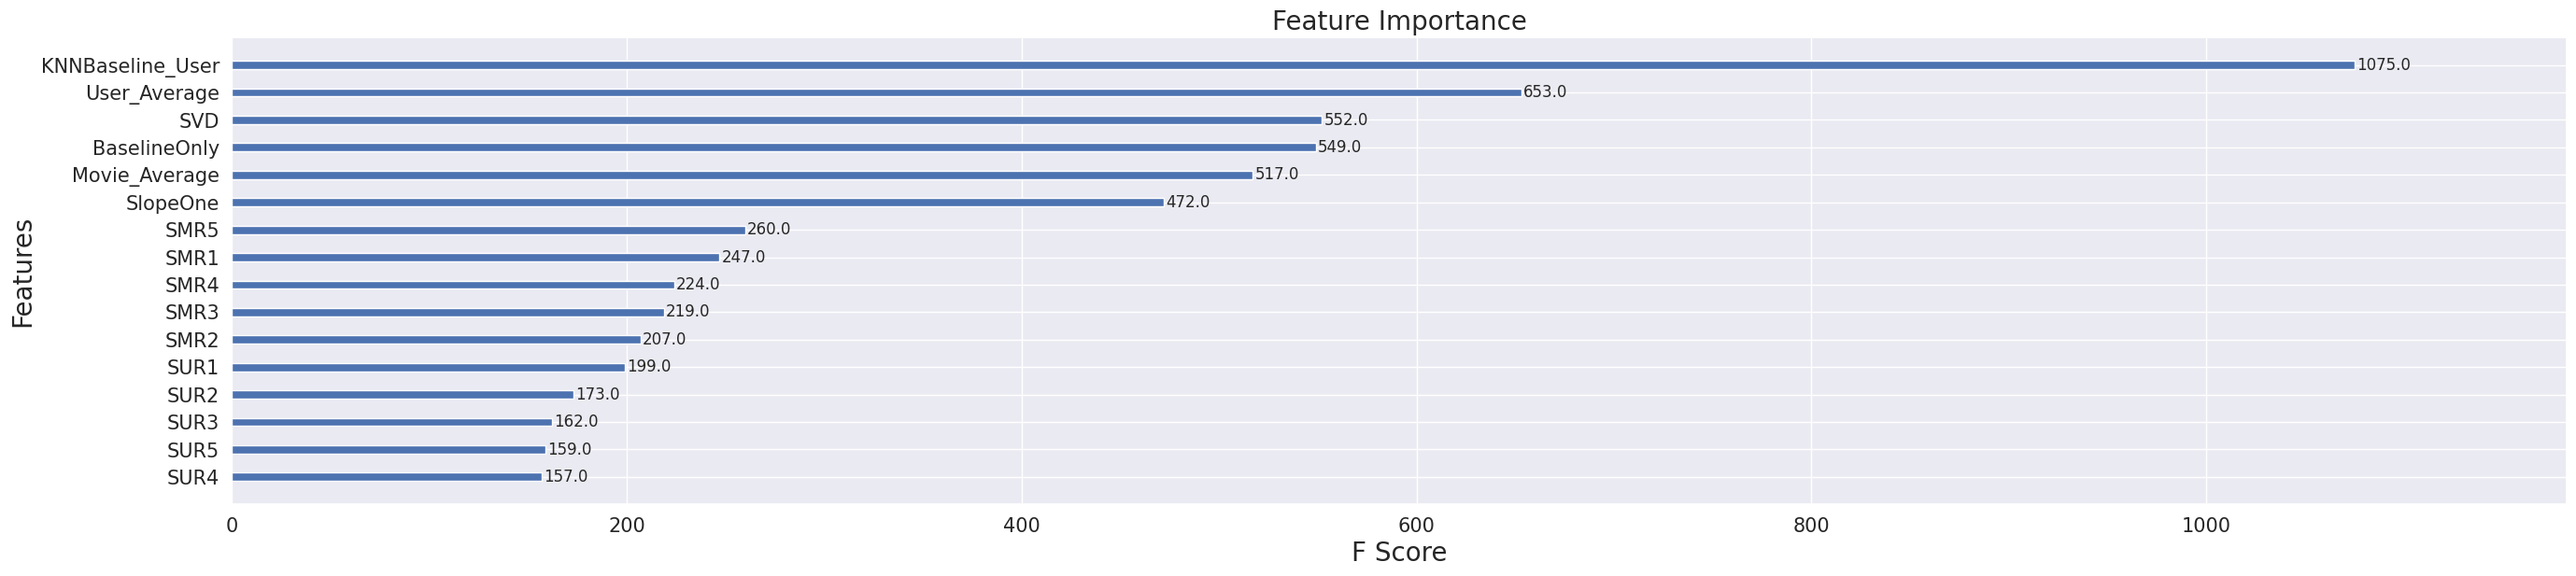

In [129]:
# Applying Xgboost on the feature set

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

Вывод:

1. SVD показал лучшие результаты, чем KNNBaseline, но SVDpp оказался наиболее неэффективным предиктором.

--------------------------------------------------
TRAIN DATA
RMSE : 0.1470039193961241
MAPE : 3.534363582798447
--------------------------------------------------
TEST DATA
RMSE : 1.0000799707902348
MAPE : 35.576171835569085
--------------------------------------------------
Time Taken :  0:00:10.088426


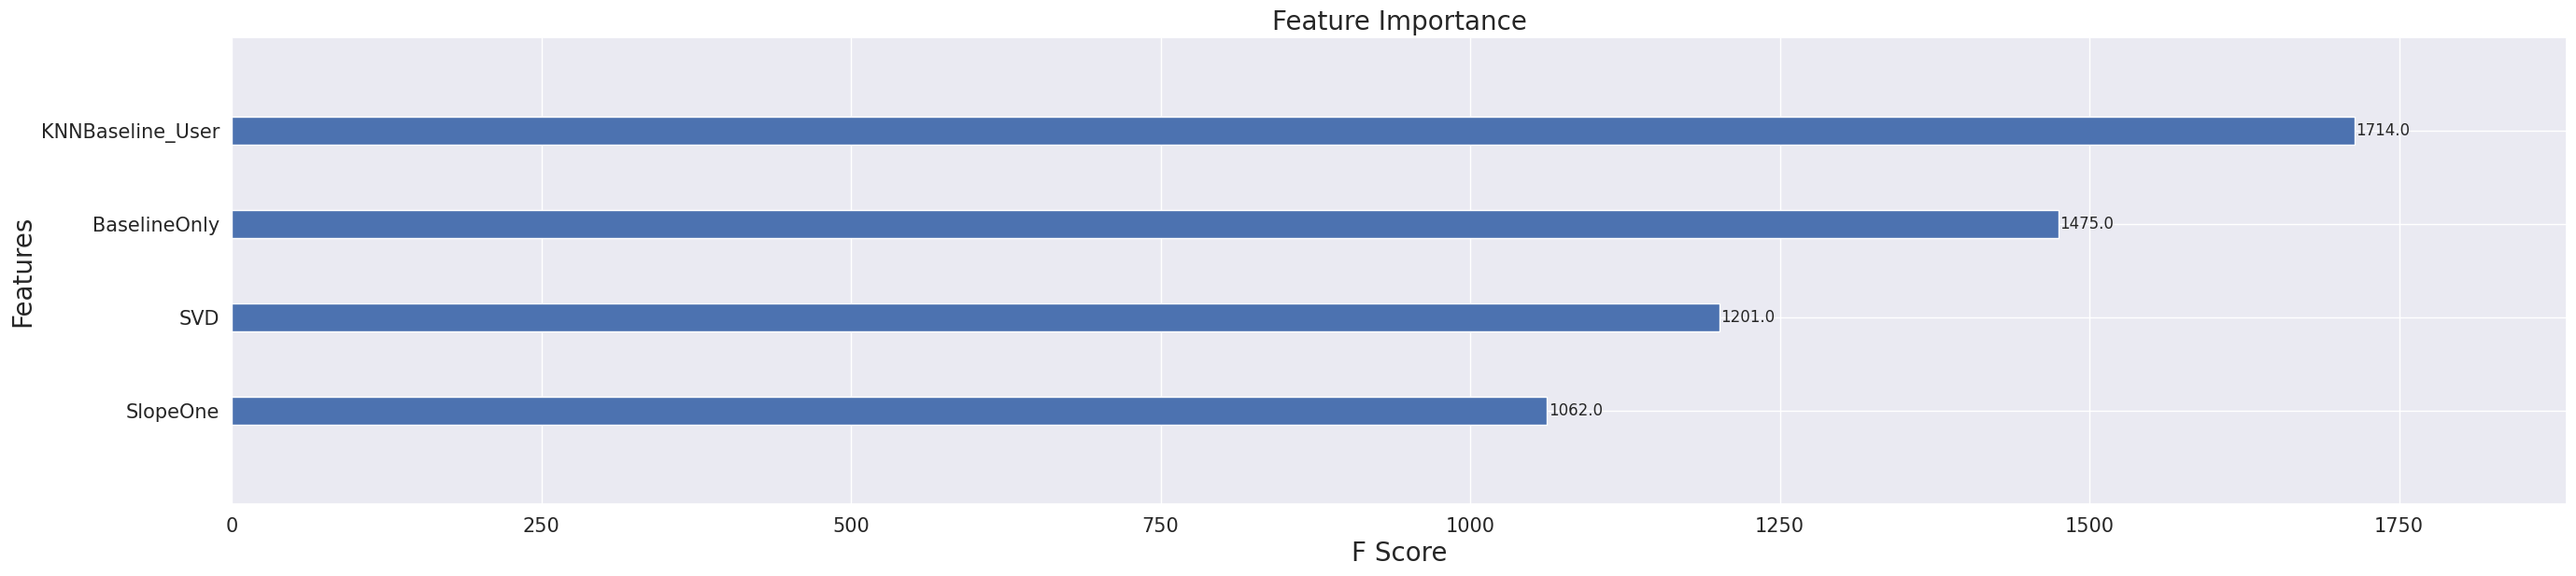

In [130]:
# Applying Xgboost with Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne

x_train = train_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]
x_test = test_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF_SO")

model_train_evaluation["XGB_KNN_MF_SO"] = train_result
model_test_evaluation["XGB_KNN_MF_SO"] = test_result

Наблюдения:

1. SVD, по-видимому, является лучшим средством оценки рейтинговых прогнозов.
2. SVDpp и только базовый уровень также, по-видимому, являются важной характеристикой.
3. Функции SlopeOne, KNNBaseline также являются достойными оценщиками.

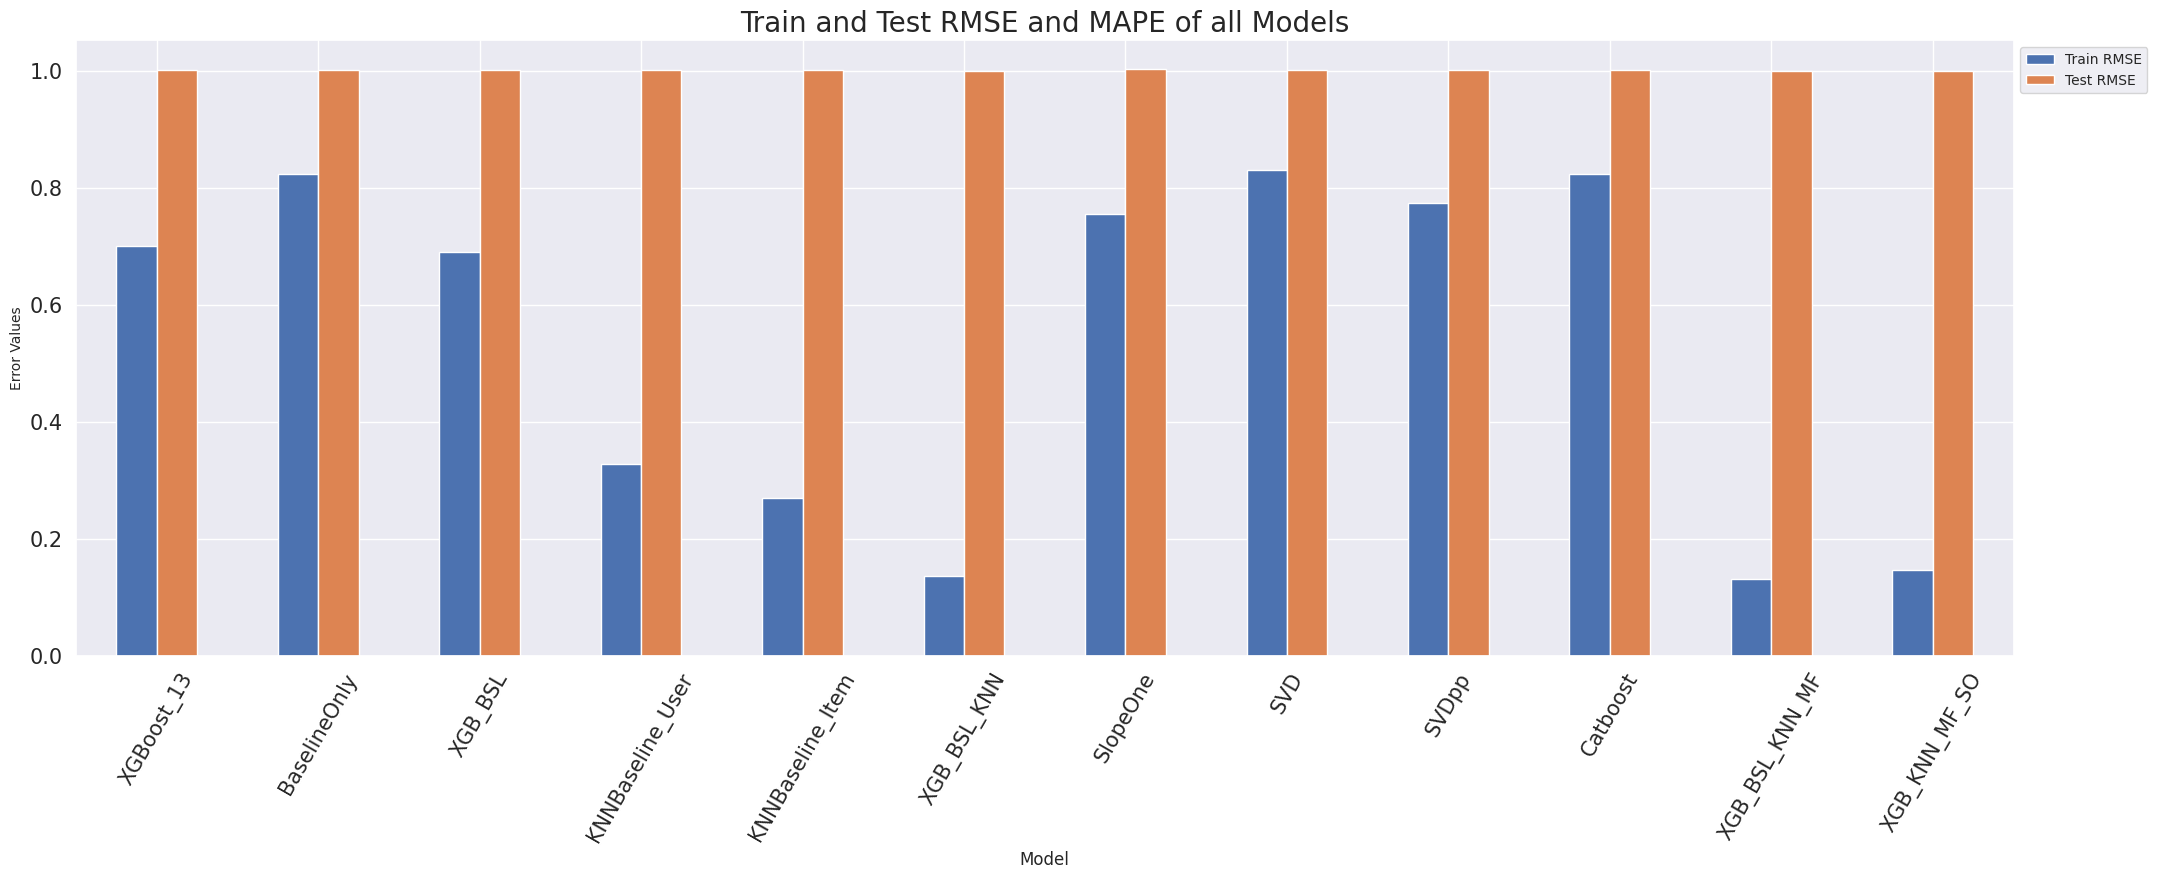

In [131]:
# Visualizing the errors of all the models we tested out

error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (25, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 10)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 10)
plt.show()

In [132]:
# Tabular Values of Errors
error_table
# error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

,Model,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,XGBoost_13,0.700361,22.126592,1.000999,35.579223
1,BaselineOnly,0.823223,27.829451,1.001143,35.540691
2,XGB_BSL,0.689803,21.736753,1.001192,36.229775
3,KNNBaseline_User,0.327916,10.095418,1.001030,35.554710
4,KNNBaseline_Item,0.269212,8.005492,1.001007,35.554114
5,XGB_BSL_KNN,0.136277,3.236947,1.000036,35.833312
6,SlopeOne,0.754608,24.558562,1.002448,35.599408
7,SVD,0.829768,28.388505,1.000952,35.551927
8,SVDpp,0.773559,26.135336,1.000941,35.548647
9,Catboost,0.823223,27.829451,1.001143,35.540691


Вывод:
1. Все алгоритмы, по-видимому, работают отлично, при этом различия остаются очень близкими друг к другу.

2. Мы видим, что при совместном использовании различных алгоритмов прогнозирования рейтинга и их суммировании использование окончательных алгоритмов, по-видимому, приводит к наименьшему коэффициенту полезного действия при тестировании. Например: Только базовый уровень Surprises + Базовый уровень KNN + SVD + Svtpp + Slope One вместе с Xgboost.

3. Кажется, что Slope One имеет самый низкий коэффициент тестирования из всех других алгоритмов.

4. Svtpp и SVD - алгоритмы, показывающие более низкий коэффициент полезного действия при тестировании среди остальных предикторов, за исключением SlopeOne.


### **4.3 Generating Recommendation for Users**

We are using SVDpp to generate atmost 10 recommendated movies for various users.

In [133]:
# Testing the recommendations made by SVDpp Algorithm

from collections import defaultdict

def Get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, mid, true_r, est, _ in predictions:
        top_n[uid].append((mid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [134]:
# Creating instance of svd_pp

svd_pp = SVDpp(n_factors = 10, lr_all = 0.006, verbose=True)
svd_pp.fit(trainset)
predictions = svd_pp.test(testset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


In [135]:
# Saving the training predictions

train_pred = svd_pp.test(trainset.build_anti_testset())
top_n = Get_top_n(train_pred, n=10)

In [136]:
# Print the recommended items for each user

def Generate_Recommendated_Movies(u_id, n=10):

    recommend = pd.DataFrame(top_n[u_id], columns=["Movie_Id", "Predicted_Rating"])
    recommend = recommend.merge(movies, how="inner", left_on="Movie_Id", right_on="movieId")
    recommend = recommend[["Movie_Id", "title", "genres", "Predicted_Rating"]]

    return recommend[:n]

In [137]:
# Saving the sampled user id list to help generate movies

sampled_user_id = list(top_n.keys())

In [138]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  24655


,Movie_Id,title,genres,Predicted_Rating
0,7974,"Short Film About Killing, A (Krótki film o zab...",Crime|Drama,4.165640
1,3539,"Gold Rush, The (1925)",Adventure|Comedy|Romance,4.082887
2,1175,Brazil (1985),Fantasy|Sci-Fi,4.075230
3,2120,Shadow of a Doubt (1943),Crime|Drama|Thriller,4.036666
4,7216,Persona (1966),Drama,4.032454
5,895,Charade (1963),Comedy|Crime|Mystery|Romance|Thriller,4.024802
6,12933,Let the Right One In (Låt den rätte komma in) ...,Drama|Fantasy|Horror|Romance,3.989545
7,3341,Creature Comforts (1989),Animation|Comedy,3.982962
8,6743,In Cold Blood (1967),Crime|Drama,3.974903
9,6980,Horse Feathers (1932),Comedy,3.950453


In [139]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  1533


,Movie_Id,title,genres,Predicted_Rating
0,7042,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,4.717161
1,883,Singin' in the Rain (1952),Comedy|Musical|Romance,4.582711
2,6743,In Cold Blood (1967),Crime|Drama,4.571542
3,12933,Let the Right One In (Låt den rätte komma in) ...,Drama|Fantasy|Horror|Romance,4.571269
4,3890,You Can Count on Me (2000),Drama|Romance,4.531047
5,7974,"Short Film About Killing, A (Krótki film o zab...",Crime|Drama,4.517977
6,7216,Persona (1966),Drama,4.516682
7,7417,Pride and Prejudice (1995),Drama|Romance,4.509710
8,895,Charade (1963),Comedy|Crime|Mystery|Romance|Thriller,4.506409
9,1243,Back to the Future (1985),Adventure|Comedy|Sci-Fi,4.486042


## **5. Заключение**

В ходе этого проекта мы узнали о важности рекомендательных систем, о типах внедряемых рекомендательных систем и о том, как использовать матричную факторизацию для улучшения системы.

Затем мы создали систему рекомендаций по просмотру фильмов, которая учитывает сходство между пользователями, сходство между фильмами, глобальные средние значения и матричную факторизацию. Эти концепции могут быть применены к любым другим системам взаимодействия пользователей с товарами.

Мы попытались сгенерировать рекомендации на основе матрицы сходства и методов коллаборативной фильтрации.

Мы попытались спрогнозировать рейтинги фильмов, которые может выставить пользователь, основываясь на его прошлых оценках, и измерить точность с помощью показателей ошибок RMSE и MAPE.

Конечно, есть огромный объем улучшений и опробования различных методов и алгоритмов ML/DL.